En esta version TPPresion voy a repetir las pruebas del 'TP3AyudaMario' pero usando la informacion de la precipitacion del dia anterior y la presion del dia anterior en vez de usar la precipitacion acumulada de 3 dias. Ademas seguire poniendo equilibrando el undersampling solo de los datos de entrenamiento, y eligiendo parcelas enteras como datos de test.

In [1]:
def algoritmo(df2, fecha, show, parcela):
    diasTotales = 365 + 31
    #from IPython.core.display import display, HTML
    #display(HTML("<style>div.output_scroll { height: 90em; }</style>"))

    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import datetime

    import warnings
    warnings.filterwarnings("ignore")
    
    borrarDebajo = 0.15
    
    fechas = list()
    fechas2 = list()
    valores = list()
    valores2= list()
    N = int(df2.size / 3) #numero de valores que tenemos para esta parcela

    #Almacenamos los datos originales de la parcela en 'fechas' y 'valores'
    #En 'fechas2' y 'valores2' almacenamos los datos cuyo ndvi esté por encima de 'borrarDebajo'
    for i in range(N):
        data = df2.iloc[i].fecha
        data = str(data)
        #Esto convierte la cadena YYYYMMDD en un tipo de dato fecha
        dt = datetime.datetime.strptime(data, "%Y%m%d")
        dtInt = int(dt.strftime("%j"))
        if int(data) >= 20220000:
            dtInt = dtInt +365
        #Convierto ese tipo de dato fecha en un entero, el dia del año de esa fecha
        #Ej. 20210202 es el 2 de febrero y es el dia 33 del año
        fechas.append(dtInt)
        ndvi = df2.iloc[i].ndvi
        valores.append(ndvi)
        #Solo añado si el valor está por encima de la variable "borrarDebajo"
        if ndvi >= borrarDebajo:
            valores2.append(ndvi)
            fechas2.append(dtInt)

    #Borramos de 'valores2' y 'fechas2' los datos cuyos ndvi sean menores que el dato anterior y al siguiente (valores valle)
    #Ejemplo: si tenemos los valores [3,1,2,4], borramos los valores 1 y 2
    #Si tenemos los valores [3,1,4], borramos el valor 1
    #Borramos los valores valle
    for i in range(len(valores2)-1):
        if i > 0 and i < len(valores2)-1:
            #Si hay 2 valores juntos menores que el anterior y el siguiente, se borran ambos
            if i < (len(valores2) - 2) and valores2[i-1] > valores2[i] and valores2[i-1] > valores2[i+1] and valores2[i+2] > valores2[i] and valores2[i+2] > valores2[i+1]:
                del valores2[i]
                del fechas2[i]
                del valores2[i]
                del fechas2[i]
            #En el caso de que solo haya un minimo entre 2 puntos
            elif valores2[i-1] > valores2[i] and valores2[i+1] > valores2[i]:
                del valores2[i]
                del fechas2[i]        






    #Variables:
    saltoFechas = 10
    saltoFechas2 = 20
    saltoFechas3 = 30
    añadirPorDebajo = 0.4 #antes se llamaba maximoMinimo
    añadirPorEncima = 0.2

    #Añado informacion al principio y final de año si no habia
    if fechas2[0] > 0:
        fechas2.insert(0, 0)
        valores2.insert(0, valores2[0])
    if fechas2[len(fechas2) -1] < diasTotales:
        fechas2.insert(len(fechas2), diasTotales)
        valores2.insert(len(valores2), valores2[len(valores2)-1])


    #Si hay saltos muy grandes sin informacion se trata:
    i = 0
    while i < len(fechas2) - 1: 
        encontrado = False
        #Si el salto es muy grande
        if (fechas2[i+1]-fechas2[i]) >= saltoFechas3 and i+1 != (len(fechas2) -1) and i != 0:
            #buscar maximos locales entre los dos puntos y
            aux1 = 0
            aux2 = 0
            for j in range(len(fechas) - 1):
                if fechas[j] <= fechas2[i] and fechas[j+1] >= fechas2[i]:
                    aux1 = j
                elif fechas[j] <= fechas2[i]  and fechas[j+1] >= fechas2[i]   :
                    aux2 = j
                    break
            j = aux1 + 1
            auxSum = 0
            while (j < aux2):
                if valores[j] > valores[j-1] and valores[j] > valores[j+1]:
                    # y volverlos a añadir segun su valor
                    if (valores2[i] <= 0.6 and valores2[i+1] <=0.6 and valores[j] <= añadirPorDebajo and valores[j] >= añadirPorEncima):
                        fechas2.insert(i+1+ auxSum, fechas[j])
                        valores2.insert(i+1+ auxSum, valores[j])
                        auxSum = auxSum + 1
                        encontrado = True
                j = j + 1



        if encontrado == False:    
            #Si el salto es intermedio
            if (fechas2[i+1]-fechas2[i]) >= saltoFechas2:
                if valores2[i+1] > valores2[i]: #va hacia arriba
                    fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3)*2)
                    valores2.insert(i+1, valores2[i] + ((valores2[i+1] - valores2[i]) / 3))
                else: #va hacia abajo
                    fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3))
                    valores2.insert(i+1,  valores2[i+1] + ((valores2[i] - valores2[i+1]) / 3))
            #Si el salto es pequeño
            elif (fechas2[i+1]-fechas2[i]) >= saltoFechas:
                fechas2.insert(i+1, (fechas2[i+1]+fechas2[i])/2)
                valores2.insert(i+1, (valores2[i+1]+valores2[i])/2)
        i = i+1


    #Plot    
    from scipy.interpolate import make_interp_spline
    from scipy.interpolate import interp1d

    #Esto crea una linea de <diasTotales> puntos que pasa por todos los puntos que teniamos
    X_Y_Spline = make_interp_spline(fechas2,valores2)        
    X = np.linspace(0, diasTotales, diasTotales)
    Y = X_Y_Spline(X)

    dt = datetime.datetime.strptime(fecha, "%Y%m%d")
    aux = int(dt.strftime("%j"))
    
    if (show):
        plt.figure(figsize=(17,5))
        plt.title('parcela: '+ parcela)
        plt.plot(fechas, valores,'r-')

        plt.xticks(np.arange(0, diasTotales,10))

        plt.plot(X, Y, 'b-')
        plt.scatter(fechas, valores, c=valores, cmap='Set2')

        #Dibujar las lineas verticales asociadas a las fechas de recepcion
        #for recepcion in recepciones:
        #    if recepcion[0] == parcela:
        #        for aux in recepcion[1]:
        #            dt = datetime.datetime.strptime(aux, "%Y%m%d")
        #            aux2 = int(dt.strftime("%j"))
        #            plt.axvline(x=(aux2))  
        #        break

        #dt = datetime.datetime.strptime(fecha, "%Y%m%d")
        #aux = int(dt.strftime("%j"))
        plt.axvline(x=(aux))  



        plt.xlabel("X")
        plt.ylabel("Y")
        plt.ylim([0, 1])
        plt.legend(["puntos originales","puntos modificados"])
        plt.show()
        
    return [Y, aux]

def obtenerColumnas():
    columnas = list()
    columnas.append('parcela')
    columnas.append('dia')
    columnas.append('pendiente dia -15')
    columnas.append('pendiente dia -10')
    columnas.append('pendiente dia -5')
    columnas.append('ndvi')
    columnas.append('recogido')
    
    return columnas

def inicializarDataframeIA(columnas):
    import pandas as pd
    df_ia = pd.DataFrame(columns=columnas())
    
    return df_ia

def obtenerParcelasConUnaRecepcion(PARCELASMAIZ20212022CONFECHAS):
    import pandas as pd

    dfFechas = pd.read_csv(PARCELASMAIZ20212022CONFECHAS)
    
    freq = dfFechas['PAC'].value_counts()
    items = freq[freq==1].index
    only_1_reception = dfFechas[dfFechas['PAC'].isin(items)]

    newPac = only_1_reception["PAC"].str.replace(":", "_")
    newDate = only_1_reception["Fecha de carga"].str.replace("-", "")

    only_1_reception["PAC"] = newPac
    only_1_reception["Fecha de carga"] = newDate
    only_1_reception['Fecha de carga'] = only_1_reception['Fecha de carga'].apply(str)
    
    return only_1_reception

def añadirADataframe(parcela, diaDeCarga, valoresDias, columnas, df,diasPendiente, diasMargen):
    import pandas as pd
    for i in range(len(valoresDias)):
        if ((i - (diasPendiente[0])) >= 0 and (i+1) - diaDeCarga > -15 and (i+1) - diaDeCarga <= 5  ):
            
            lista = list()
            lista.append(parcela)
            lista.append(i + 1)
            for j in diasPendiente:
                lista.append((valoresDias[i - j] - valoresDias[i])/j)
                
            lista.append(valoresDias[i])
            if ((diaDeCarga - (i + 1)) <= diasMargen and (diaDeCarga - (i + 1)) >= 0):
                lista.append(1)
            else:
                lista.append(0)

            dfAux = pd.DataFrame([lista], columns=columnas(), index=[len(df)])
            df = df.append(dfAux)
    
    
    return df


def obtenerDatosEntrenables(datosNoEntrenables2122, PARCELASMAIZ20212022CONFECHAS):
    import pandas as pd
    dfFechas = obtenerParcelasConUnaRecepcion(PARCELASMAIZ20212022CONFECHAS)
    
    
    dfDatos = pd.read_csv(datosNoEntrenables2122)
    dfDatos = dfDatos.sort_values(by=["fecha","parcela"], ascending=True)
    
    parcelasQueTengo = dfDatos["parcela"].unique()
    parcelasConUnaRecepcion = dfFechas["PAC"].unique()

    df_ndvi_of_only_1_reception = dfDatos[dfDatos.parcela.isin(dfFechas["PAC"].unique())]
    parcelas = df_ndvi_of_only_1_reception['parcela'].unique()
    
    
    df = inicializarDataframeIA(obtenerColumnas)
    i = 0
    j = len(parcelas)
    diaPrimeraRecepcion = [15,10,5]
    diaMargen = 4
    
    
    for parcela in parcelas:

        df2 = df_ndvi_of_only_1_reception.loc[df_ndvi_of_only_1_reception['parcela'] == parcela]
        df2 = df2.drop_duplicates()
        if (not df2.empty):
            fecha_df = dfFechas.loc[dfFechas["PAC"] == parcela] 
            fecha = fecha_df.iloc[0]["Fecha de carga"]
            X, dia_recepcion = algoritmo(df2, fecha, True, parcela)
            if (dia_recepcion > diaPrimeraRecepcion[0]):
                df = añadirADataframe(parcela, dia_recepcion, X, obtenerColumnas, df, diaPrimeraRecepcion, diaMargen)
            i = i + 1
            print(str(i) + "/" + str(j)) 
        else:
            j = j - 1
        

    return df

def separarTrainTest(dataframe):
    parcelas = dataframe['parcela'].unique()
    N = len(parcelas)

    #si hay 2 recintos de la misma zona uno lo meto a test
    test= list()
    train = list(parcelas)
    contador = 1
    for i in range(N):
        parcelaAnterior = parcelas[i - 1].split('_')
        aux = ''
        for j in range(5):
            aux = aux + parcelaAnterior[j] + '_'


        if parcelas[i].startswith(aux):
            test.append(parcelas[i])
            train.remove(parcelas[i])
            if len(test) >= N * 0.1:
                break

    dataframeTrain = dataframe[dataframe['parcela'].isin(train)]
    dataframeTest =  dataframe[dataframe['parcela'].isin(test)]
    
    return [dataframeTrain, dataframeTest]

def obtenerModelo(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    model.add(normalizer)
    #,kernel_initializer=initializer
    #model.add(Dense(n**3, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    #añadir capa
    model.add(Dense(n**2, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    model.add(Dense(n, activation='relu', kernel_regularizer=l2(regularizacion)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(regularizacion)))
    #
    model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall', threshold = 0.6)])
    model.summary()
    
    return model

def obtenerModelo3(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    model.add(normalizer)
    #,kernel_initializer=initializer
    #model.add(Dense(n**3, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    #añadir capa
    #model.add(Dense(n**2, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    model.add(Dense(n, activation='relu',input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(regularizacion)))
    #
    model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall')])
    model.summary()
    
    return model

def obtenerModelo4(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    model.add(normalizer)
    #,kernel_initializer=initializer
    model.add(Dense(n**3, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    #añadir capa
    model.add(Dense(n**2, activation='relu',  kernel_regularizer=l2(regularizacion)))
    model.add(Dense(n, activation='relu', kernel_regularizer=l2(regularizacion)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(regularizacion)))
    #
    model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall', threshold = 0.6)])
    model.summary()
    
    return model

def obtenerModelo5(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    from tensorflow.keras.layers import Dropout
    from tensorflow.keras.constraints import MaxNorm
    from tensorflow.keras.optimizers import SGD
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    model.add(normalizer)
    #,kernel_initializer=initializer
    # Compile model
    #añadir capa
    model.add(Dense(n, activation='relu', input_shape=(n,), kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='relu', kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    #
    sgd = SGD(learning_rate=0.1, momentum=0.9)
    model.compile(loss='binary_crossentropy', optimizer=sgd,  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall')])
    model.summary()
    
    return model

def obtenerModelo2(dataframeTrain):
    # Perceptron de un solo nivel
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    normalizer = layers.Normalization()
    normalizer.adapt(X) 
    
    model = Sequential()
    
    #model.add(normalizer)
    
    model.add(Dense(4096, kernel_initializer='normal',input_dim = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1], activation='sigmoid'))

    # The Hidden Layers :
    model.add(Dense(2048 ,activation='softmax'))
    model.add(Dense(1024 ,activation='sigmoid'))
    model.add(Dense(512,activation='relu'))
    model.add(Dense(256,activation='softmax'))
    model.add(Dense(128,activation='sigmoid'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32,activation='softmax'))
    model.add(Dense(16,activation='sigmoid'))
    model.add(Dense(8,activation='relu'))
    model.add(Dense(4,activation='softmax'))
    
    model.add(Dense(2, activation='softmax'))
    #
    model.compile(loss='categorical_crossentropy', optimizer=Adam(),  metrics=['accuracy'])
    model.summary()
    
    return model

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    fig, axs = plt.subplots(1, 2,  figsize=(12, 6))
    for l in loss_list:
        axs[0].plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        axs[0].plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    axs[0].set(title='Loss', xlabel='Epochs', ylabel='Loss')
    axs[0].grid()
    axs[0].legend()
    
    ## Accuracy
    for l in acc_list:
        axs[1].plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        axs[1].plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    axs[1].set(title='Accuracy', xlabel='Epochs', ylabel='Accuracy')
    axs[1].grid()
    axs[1].legend()
    plt.show()
    
def anyadirUnos(df):
    df['unos'] = [1]*len(df)
    
def RecepcionToBool(recogido):
    aux = np.zeros(2)
    aux[recogido] = 1
    return aux
            
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    #plt.tight_layout()

def plot_mnist_confusion_matrix(y_test, y_pred, normalize=False):
    from sklearn.metrics import confusion_matrix
    
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers
    umbral = 0.01
    
    y_tst = np.zeros(len(y_test))
    for i in range(len(y_test) - 1):
        #if y_test[i][1] >= umbral:
        #    y_tst[i] = 1
        y_tst[i] = np.argmax(y_test[i])
    #y_tst = [np.argmax(y) for y in y_test]
    
    y_prd = np.zeros(len(y_pred))
    for i in range(len(y_pred) - 1):
        #if y_pred[i][1] >= umbral:
        #    y_prd[i] = 1
        y_prd[i] = np.argmax(y_pred[i])
    #y_prd = [np.argmax(y) for y in y_pred]

    cnf_matrix = confusion_matrix(y_tst, y_prd)
    
    yprueba = list()
    for y in y_tst:
        yprueba.append(y)
    for y in y_prd:
        yprueba.append(y)
    class_names=np.unique(yprueba)
    print(class_names)
    plt.figure(figsize=(20,20))
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          normalize=normalize)
    
def quitarDatosMalos(df):
    #QUITA LAS PARCELAS QUE NO TENGAN 20 DIAS DE DATOS
    parcelasAQuitar = list()
    parcelas = df['parcela'].unique()
    for parcela in parcelas:
        if len(df.loc[df['parcela'] == parcela]) != 20:
            parcelasAQuitar.append(parcela)
    
    df = df[~df['parcela'].isin(parcelasAQuitar)]
    return df
    
def anyadirRelacionesParametros2(df):
    columnas = df.shape[1]
    for i in range(columnas):
        for j in range(columnas):
            if i < j:
                nombreColumna = 'col ' + str(i+1) + ' * col ' + str(j+1)
                df[nombreColumna] = df.iloc[:,i] * df.iloc[:,j]
                
    return df
    
def anyadirRelacionesParametros(df, listaColumnas = ['parcela','dia','recogido','ndvi']):
    aux = pd.DataFrame()
    for i in listaColumnas:
        aux[i] = df[i]
        df = df.drop(columns=[i])
        
    df = anyadirRelacionesParametros2(df)
    for i in listaColumnas:
        df[i] = aux[i]
    return df
    
def entrenarModelo(model, dataframeTrain, dataframeTest, batch_size, epochs, callbacks_list):
    def RecepcionToBool(recogido):
        aux = np.zeros(2)
        aux[recogido] = 1
        return aux

    #DATA TRAINING   
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers
    N = len(dataframeTrain)


    verbose = True
    t0 = time.perf_counter()
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    y = np.asarray(dataframeTrain[["recogido"]]).astype(np.float32)
    
    #DATA TESTING
    N = len(dataframeTest)

    Xtest = np.asarray(dataframeTest.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    ytest = np.asarray(dataframeTest[["recogido"]]).astype(np.float32)
    


    history = model.fit(X, y,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=False, 
                        callbacks=callbacks_list,
                       validation_data=(Xtest,ytest))

    #model.predict(X_cv)

    train_time = time.perf_counter() - t0
    print('%s %.3f%s' %  ('Training time: ', train_time, 's') )
    plot_history(history)
    
def predecirYMostrarMatrizConfusion(df,model,pesos, umbral = 0.6):
    df = df.reset_index()
    df = df.drop(columns=['index'])
    X = df.drop(columns=['parcela','dia','recogido'])
    y = df['recogido']
    
    X=np.asarray(X).astype(np.float)

    y=np.asarray(y).astype(np.float)
    
    model.load_weights(pesos)
    
    
    
    y_pred = model.predict(X, verbose=True)
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(y_pred)):
        if y_pred[i] >= umbral and y[i] == 1:
            tp = tp + 1
        elif y_pred[i] >= umbral and y[i] == 0:
            fp = fp + 1
        elif y_pred[i] < umbral and y[i] == 1:
            fn = fn + 1
        else:
            tn = tn + 1


    test_score = (tp + tn)/ len(X)
    print('%s %2.2f%s' % ('Accuracy test:  ', 100*test_score, '%'))

    import seaborn as sn
    import pandas as pd
    import matplotlib.pyplot as plt
    ind = np.asarray([0.0,1.0]).astype(np.float32)
    mat = np.asarray([[tn, fp], [fn, tp]]).astype(np.int32)
    plt.figure(figsize=(20,20))
    plot_confusion_matrix(mat, classes=ind,
                              normalize=False)



# Define la función de poda
def prune_low_weights(model, pruning_threshold):
    from keras import backend as K
    for layer in model.layers:
        if hasattr(layer, 'kernel_regularizer'):
            weights = layer.get_weights()[0]  # Obtiene los pesos de la capa
            mask = K.abs(weights) > pruning_threshold  # Aplica el umbral
            weights *= mask  # Poda los pesos por debajo del umbral
            layer.set_weights([weights])  # Establece los pesos podados en la capa
            
def parcelasConAciertos(dataframe,model,  umbral = 0.6, verbose=1, XGBoost = False, LGBM= False):
    import lightgbm as lgb
    import xgboost as xgb
    dataframeRecogidoUno = dataframe.loc[dataframe['recogido'] == 1]
    parcelasAObservar = dataframe['parcela'].unique()
    parcelasSinResultado = list(dataframe['parcela'].unique())
    if verbose == 1:
        print(len(parcelasSinResultado))
        print("hay ", str(len(parcelasAObservar)), " parcelas a observar")
        print('------------------')
    cantidad = 0
    for parcela in parcelasAObservar:
        unoAcertado = False
        datos = dataframe.loc[dataframe['parcela'] == parcela]
        dias = dataframeRecogidoUno.loc[dataframeRecogidoUno['parcela'] == parcela]['dia']
        if verbose == 1:
            print(parcela, 'dias que deberia dar 1 la prediccion:')
            print(dias)
        Xtest = np.asarray(dataframe.loc[dataframe['parcela'] == parcela].drop(columns=['parcela','dia','recogido'])).astype(np.float32)
        ytest = np.asarray(dataframe.loc[dataframe['parcela'] == parcela][["recogido"]]).astype(np.float32)
        
        # preparar datos de xgboost
        if XGBoost == True:
            X_test = pd.DataFrame(Xtest, columns=dataframe.drop(columns=['recogido','parcela','dia']).columns)
            Xtest = xgb.DMatrix(X_test, label=ytest)
        # preparar datos de lgbm
        elif LGBM == True:
            X_test = pd.DataFrame(Xtest, columns=dataframe.drop(columns=['recogido','parcela','dia']).columns)
            Xtest = X_test.values
        
        # predicciones
        if hasattr(model, 'predict_proba'):
            ypred = model.predict_proba(Xtest)[:,1]
        else:
            if 'verbose' in model.predict.__code__.co_varnames:
                ypred = model.predict(Xtest, verbose=verbose)
            else:
                ypred = model.predict(Xtest)
            
            
        if verbose == 1:
            print("dias que ha dado 1 la prediccion: ")
        for i in range(len(ypred)):
            if ypred[i] >= umbral:
                if verbose == 1:
                    print('dia: ', datos.iloc[i]['dia'])
                if ytest[i] == 1 and unoAcertado == False:
                    cantidad = cantidad + 1
                    unoAcertado = True
                    
                    
        if (unoAcertado == True):
            if verbose == 1:
                print("ha acertado por lo menos un 1 de los que deberia")
            parcelasSinResultado.remove(parcela)

        if verbose == 1:
            print('------------------')

    print('Parcelas con acierto: ',cantidad, "de", str(len(parcelasAObservar)) , " ", "{:.2%}".format(cantidad/len(parcelasAObservar)))
    return [parcelasAObservar, parcelasSinResultado]
    
    
def obtenerMejorModelo(directory_init = ''):
    import os
    import ipynbname
    if directory_init == '':
        directory = ipynbname.name()
    else:
        directory = directory_init
    baccuracyMax = 0
    baccuracyMaxFile = ''
    val_baccuracyMax = 0
    val_baccuracyMaxFile = ''
    recallMax = 0
    recallMaxFile = ''
    val_recallMax = 0
    val_recallMaxFile = ''
    # iterate over files in
    # that directory
    for subdirectory in os.listdir(directory):
        f = os.path.join(directory, subdirectory)
        # checking if it is a file
        for filename in os.listdir(f):
            campos = filename.split('-')
            f1 = os.path.join(f, filename)
            if (len(campos)) == 5:
                if (campos[3] == 'binary_accuracy' and float(campos[4][:len(campos[4])-5]) > float(baccuracyMax)):
                    baccuracyMax = float(campos[4][:len(campos[4])-5])
                    baccuracyMaxFile = f1
                if (campos[3] == 'val_binary_accuracy' and float(campos[4][:len(campos[4])-5]) > float(val_baccuracyMax)):
                    val_baccuracyMax = float(campos[4][:len(campos[4])-5])
                    val_baccuracyMaxFile = f1
                if (campos[3] == 'recall' and float(campos[4][:len(campos[4])-5]) > float(recallMax)):
                    recallMax = float(campos[4][:len(campos[4])-5])
                    recallMaxFile = f1
                if (campos[3] == 'val_recall' and float(campos[4][:len(campos[4])-5]) > float(val_recallMax)):
                    val_recallMax = float(campos[4][:len(campos[4])-5])
                    val_recallMaxFile = f1

    print("Mejor binary_accuracy: ", baccuracyMax)
    print(baccuracyMaxFile)
    print("Mejor val_binary_accuracy: ", val_baccuracyMax)
    print(val_baccuracyMaxFile)
    print("Mejor recall: ", recallMax)
    print(recallMaxFile)
    print("Mejor val_recall: ", val_recallMax)
    print(val_recallMaxFile)


In [2]:
def mostrarParcelasSinAciertos(parcelasAObservar):

    def algoritmo(df2, fecha, show, tp, fp):

        #from IPython.core.display import display, HTML
        #display(HTML("<style>div.output_scroll { height: 90em; }</style>"))

        import pandas as pd
        import matplotlib.pyplot as plt
        import numpy as np
        import datetime

        import warnings
        warnings.filterwarnings("ignore")

        borrarDebajo = 0.15

        fechas = list()
        fechas2 = list()
        valores = list()
        valores2= list()
        N = int(df2.size / 3) #numero de valores que tenemos para esta parcela

        #Almacenamos los datos originales de la parcela en 'fechas' y 'valores'
        #En 'fechas2' y 'valores2' almacenamos los datos cuyo ndvi esté por encima de 'borrarDebajo'
        for i in range(N):
            data = df2.iloc[i].fecha
            data = str(data)
            #Esto convierte la cadena YYYYMMDD en un tipo de dato fecha
            dt = datetime.datetime.strptime(data, "%Y%m%d")
            #Convierto ese tipo de dato fecha en un entero, el dia del año de esa fecha
            #Ej. 20210202 es el 2 de febrero y es el dia 33 del año
            fechas.append(int(dt.strftime("%j")))
            ndvi = df2.iloc[i].ndvi
            valores.append(ndvi)
            #Solo añado si el valor está por encima de la variable "borrarDebajo"
            if ndvi >= borrarDebajo:
                valores2.append(ndvi)
                fechas2.append(int(dt.strftime("%j")))

        #Borramos de 'valores2' y 'fechas2' los datos cuyos ndvi sean menores que el dato anterior y al siguiente (valores valle)
        #Ejemplo: si tenemos los valores [3,1,2,4], borramos los valores 1 y 2
        #Si tenemos los valores [3,1,4], borramos el valor 1
        #Borramos los valores valle
        for i in range(len(valores2)-1):
            if i > 0 and i < len(valores2)-1:
                #Si hay 2 valores juntos menores que el anterior y el siguiente, se borran ambos
                if i < (len(valores2) - 2) and valores2[i-1] > valores2[i] and valores2[i-1] > valores2[i+1] and valores2[i+2] > valores2[i] and valores2[i+2] > valores2[i+1]:
                    del valores2[i]
                    del fechas2[i]
                    del valores2[i]
                    del fechas2[i]
                #En el caso de que solo haya un minimo entre 2 puntos
                elif valores2[i-1] > valores2[i] and valores2[i+1] > valores2[i]:
                    del valores2[i]
                    del fechas2[i]        






        #Variables:
        saltoFechas = 10
        saltoFechas2 = 20
        saltoFechas3 = 30
        añadirPorDebajo = 0.4 #antes se llamaba maximoMinimo
        añadirPorEncima = 0.2

        #Añado informacion al principio y final de año si no habia
        if fechas2[0] > 0:
            fechas2.insert(0, 0)
            valores2.insert(0, valores2[0])
        if fechas2[len(fechas2) -1] < 365:
            fechas2.insert(len(fechas2), 365)
            valores2.insert(len(valores2), valores2[len(valores2)-1])


        #Si hay saltos muy grandes sin informacion se trata:
        i = 0
        while i < len(fechas2) - 1: 
            encontrado = False
            #Si el salto es muy grande
            if (fechas2[i+1]-fechas2[i]) >= saltoFechas3 and i+1 != (len(fechas2) -1) and i != 0:
                #buscar maximos locales entre los dos puntos y
                aux1 = 0
                aux2 = 0
                for j in range(len(fechas) - 1):
                    if fechas[j] <= fechas2[i] and fechas[j+1] >= fechas2[i]:
                        aux1 = j
                    elif fechas[j] <= fechas2[i]  and fechas[j+1] >= fechas2[i]   :
                        aux2 = j
                        break
                j = aux1 + 1
                auxSum = 0
                while (j < aux2):
                    if valores[j] > valores[j-1] and valores[j] > valores[j+1]:
                        # y volverlos a añadir segun su valor
                        if (valores2[i] <= 0.6 and valores2[i+1] <=0.6 and valores[j] <= añadirPorDebajo and valores[j] >= añadirPorEncima):
                            fechas2.insert(i+1+ auxSum, fechas[j])
                            valores2.insert(i+1+ auxSum, valores[j])
                            auxSum = auxSum + 1
                            encontrado = True
                    j = j + 1



            if encontrado == False:    
                #Si el salto es intermedio
                if (fechas2[i+1]-fechas2[i]) >= saltoFechas2:
                    if valores2[i+1] > valores2[i]: #va hacia arriba
                        fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3)*2)
                        valores2.insert(i+1, valores2[i] + ((valores2[i+1] - valores2[i]) / 3))
                    else: #va hacia abajo
                        fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3))
                        valores2.insert(i+1,  valores2[i+1] + ((valores2[i] - valores2[i+1]) / 3))
                #Si el salto es pequeño
                elif (fechas2[i+1]-fechas2[i]) >= saltoFechas:
                    fechas2.insert(i+1, (fechas2[i+1]+fechas2[i])/2)
                    valores2.insert(i+1, (valores2[i+1]+valores2[i])/2)
            i = i+1


        #Plot    
        from scipy.interpolate import make_interp_spline
        from scipy.interpolate import interp1d

        #Esto crea una linea de 365 puntos que pasa por todos los puntos que teniamos
        X_Y_Spline = make_interp_spline(fechas2,valores2)        
        X = np.linspace(0, 365, 365)
        Y = X_Y_Spline(X)

        dt = datetime.datetime.strptime(fecha, "%Y%m%d")
        aux = int(dt.strftime("%j"))

        if (show):
            plt.figure(figsize=(17,5))
            plt.title('parcela: '+ parcela)
            plt.plot(fechas, valores,'r-')

            plt.xticks(np.arange(0, 365,10))

            plt.plot(X, Y, 'b-')
            plt.scatter(fechas, valores, c=valores, cmap='Set2')

            #Dibujar las lineas verticales asociadas a las fechas de recepcion
            #for recepcion in recepciones:
            #    if recepcion[0] == parcela:
            #        for aux in recepcion[1]:
            #            dt = datetime.datetime.strptime(aux, "%Y%m%d")
            #            aux2 = int(dt.strftime("%j"))
            #            plt.axvline(x=(aux2))  
            #        break

            #dt = datetime.datetime.strptime(fecha, "%Y%m%d")
            #aux = int(dt.strftime("%j"))
            plt.axvline(x=(aux), linewidth=2, color='black') 
            [plt.axvline(_x, linewidth=1, color='r') for _x in fp]
            [plt.axvline(_x, linewidth=1, color='g') for _x in tp]







            plt.xlabel("X")
            plt.ylabel("Y")
            plt.ylim([0, 1])
            plt.legend(["puntos originales","puntos modificados","recepcion", "falsos positivo"])
            plt.show()

        return [Y, aux]

    import pandas as pd
    import numpy as np

    dfFechas = pd.read_csv('PARCELAS-MAIZ-2021-2022-CON-FECHAS.csv')

    freq = dfFechas['PAC'].value_counts()
    items = freq[freq==1].index
    only_1_reception = dfFechas[dfFechas['PAC'].isin(items)]

    newPac = only_1_reception["PAC"].str.replace(":", "_")
    newDate = only_1_reception["Fecha de carga"].str.replace("-", "")

    only_1_reception["PAC"] = newPac
    only_1_reception["Fecha de carga"] = newDate
    only_1_reception['Fecha de carga'] = only_1_reception['Fecha de carga'].apply(str)

    df = pd.read_csv('TODOSLOSRECINTOS.csv')

    #Ordeno por fecha y parcela
    sorted_df = df.sort_values(by=["fecha","parcela"], ascending=True)
    sorted_df = sorted_df.drop(columns=['Unnamed: 0'])
    parcelasQueTengo = sorted_df["parcela"].unique()
    parcelasConUnaRecepcion = only_1_reception["PAC"].unique()

    df_ndvi_of_only_1_reception = sorted_df[sorted_df.parcela.isin(only_1_reception["PAC"].unique())]

    dias1 = 7
    dias2 = 180


    i = 0
    #parcelas = df_ndvi_of_only_1_reception['parcela'].unique()
    parcelas = parcelasAObservar
    for parcela in parcelas:
        df2 = df_ndvi_of_only_1_reception.loc[df_ndvi_of_only_1_reception['parcela'] == parcela]
        df2 = df2.drop_duplicates()
        if (not df2.empty):
            fecha_df = only_1_reception.loc[only_1_reception["PAC"] == parcela] 
            fecha = fecha_df.iloc[0]["Fecha de carga"]

            datos = dataframeAux.loc[dataframeAux['parcela'] == parcela]
            dias = dataframeDias.loc[dataframeDias['parcela'] == parcela]['dia']
            #print('------------------')
            #print(parcela, 'dias:')
            tp = list(dias)
            #print(dias)
            Xtest = np.asarray(dataframeAux.loc[dataframeAux['parcela'] == parcela].drop(columns=['parcela','dia','recogido'])).astype(np.float32)
            ytest = np.asarray(dataframeAux.loc[dataframeAux['parcela'] == parcela][["recogido"]]).astype(np.float32)
            ypred = model.predict(Xtest, verbose=0)
            fp = list()
            for i in range(len(ypred)):
                if ypred[i] >= 0.6:
                    fp.append(datos.iloc[i]['dia'])


            X, dia_recepcion = algoritmo(df2, fecha, True, tp, fp)

            i = i + 1





def mostrarParcelasConAciertos(parcelasAObservar):
    def intersection(lst1, lst2):
                lst3 = [value for value in lst1 if value in lst2]
                return lst3
    def algoritmo(df2, fecha, show, tp, fp):

        #from IPython.core.display import display, HTML
        #display(HTML("<style>div.output_scroll { height: 90em; }</style>"))

        import pandas as pd
        import matplotlib.pyplot as plt
        import numpy as np
        import datetime

        import warnings
        warnings.filterwarnings("ignore")

        borrarDebajo = 0.15

        fechas = list()
        fechas2 = list()
        valores = list()
        valores2= list()
        N = int(df2.size / 3) #numero de valores que tenemos para esta parcela

        #Almacenamos los datos originales de la parcela en 'fechas' y 'valores'
        #En 'fechas2' y 'valores2' almacenamos los datos cuyo ndvi esté por encima de 'borrarDebajo'
        for i in range(N):
            data = df2.iloc[i].fecha
            data = str(data)
            #Esto convierte la cadena YYYYMMDD en un tipo de dato fecha
            dt = datetime.datetime.strptime(data, "%Y%m%d")
            #Convierto ese tipo de dato fecha en un entero, el dia del año de esa fecha
            #Ej. 20210202 es el 2 de febrero y es el dia 33 del año
            fechas.append(int(dt.strftime("%j")))
            ndvi = df2.iloc[i].ndvi
            valores.append(ndvi)
            #Solo añado si el valor está por encima de la variable "borrarDebajo"
            if ndvi >= borrarDebajo:
                valores2.append(ndvi)
                fechas2.append(int(dt.strftime("%j")))

        #Borramos de 'valores2' y 'fechas2' los datos cuyos ndvi sean menores que el dato anterior y al siguiente (valores valle)
        #Ejemplo: si tenemos los valores [3,1,2,4], borramos los valores 1 y 2
        #Si tenemos los valores [3,1,4], borramos el valor 1
        #Borramos los valores valle
        for i in range(len(valores2)-1):
            if i > 0 and i < len(valores2)-1:
                #Si hay 2 valores juntos menores que el anterior y el siguiente, se borran ambos
                if i < (len(valores2) - 2) and valores2[i-1] > valores2[i] and valores2[i-1] > valores2[i+1] and valores2[i+2] > valores2[i] and valores2[i+2] > valores2[i+1]:
                    del valores2[i]
                    del fechas2[i]
                    del valores2[i]
                    del fechas2[i]
                #En el caso de que solo haya un minimo entre 2 puntos
                elif valores2[i-1] > valores2[i] and valores2[i+1] > valores2[i]:
                    del valores2[i]
                    del fechas2[i]        






        #Variables:
        saltoFechas = 10
        saltoFechas2 = 20
        saltoFechas3 = 30
        añadirPorDebajo = 0.4 #antes se llamaba maximoMinimo
        añadirPorEncima = 0.2

        #Añado informacion al principio y final de año si no habia
        if fechas2[0] > 0:
            fechas2.insert(0, 0)
            valores2.insert(0, valores2[0])
        if fechas2[len(fechas2) -1] < 365:
            fechas2.insert(len(fechas2), 365)
            valores2.insert(len(valores2), valores2[len(valores2)-1])


        #Si hay saltos muy grandes sin informacion se trata:
        i = 0
        while i < len(fechas2) - 1: 
            encontrado = False
            #Si el salto es muy grande
            if (fechas2[i+1]-fechas2[i]) >= saltoFechas3 and i+1 != (len(fechas2) -1) and i != 0:
                #buscar maximos locales entre los dos puntos y
                aux1 = 0
                aux2 = 0
                for j in range(len(fechas) - 1):
                    if fechas[j] <= fechas2[i] and fechas[j+1] >= fechas2[i]:
                        aux1 = j
                    elif fechas[j] <= fechas2[i]  and fechas[j+1] >= fechas2[i]   :
                        aux2 = j
                        break
                j = aux1 + 1
                auxSum = 0
                while (j < aux2):
                    if valores[j] > valores[j-1] and valores[j] > valores[j+1]:
                        # y volverlos a añadir segun su valor
                        if (valores2[i] <= 0.6 and valores2[i+1] <=0.6 and valores[j] <= añadirPorDebajo and valores[j] >= añadirPorEncima):
                            fechas2.insert(i+1+ auxSum, fechas[j])
                            valores2.insert(i+1+ auxSum, valores[j])
                            auxSum = auxSum + 1
                            encontrado = True
                    j = j + 1



            if encontrado == False:    
                #Si el salto es intermedio
                if (fechas2[i+1]-fechas2[i]) >= saltoFechas2:
                    if valores2[i+1] > valores2[i]: #va hacia arriba
                        fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3)*2)
                        valores2.insert(i+1, valores2[i] + ((valores2[i+1] - valores2[i]) / 3))
                    else: #va hacia abajo
                        fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3))
                        valores2.insert(i+1,  valores2[i+1] + ((valores2[i] - valores2[i+1]) / 3))
                #Si el salto es pequeño
                elif (fechas2[i+1]-fechas2[i]) >= saltoFechas:
                    fechas2.insert(i+1, (fechas2[i+1]+fechas2[i])/2)
                    valores2.insert(i+1, (valores2[i+1]+valores2[i])/2)
            i = i+1


        #Plot    
        from scipy.interpolate import make_interp_spline
        from scipy.interpolate import interp1d

        #Esto crea una linea de 365 puntos que pasa por todos los puntos que teniamos
        X_Y_Spline = make_interp_spline(fechas2,valores2)        
        X = np.linspace(0, 365, 365)
        Y = X_Y_Spline(X)

        dt = datetime.datetime.strptime(fecha, "%Y%m%d")
        aux = int(dt.strftime("%j"))

        if (show):
            plt.figure(figsize=(17,5))
            plt.title('parcela: '+ parcela)
            plt.plot(fechas, valores,'r-')

            plt.xticks(np.arange(0, 365,10))

            plt.plot(X, Y, 'b-')
            plt.scatter(fechas, valores, c=valores, cmap='Set2')

            #Dibujar las lineas verticales asociadas a las fechas de recepcion
            #for recepcion in recepciones:
            #    if recepcion[0] == parcela:
            #        for aux in recepcion[1]:
            #            dt = datetime.datetime.strptime(aux, "%Y%m%d")
            #            aux2 = int(dt.strftime("%j"))
            #            plt.axvline(x=(aux2))  
            #        break

            #dt = datetime.datetime.strptime(fecha, "%Y%m%d")
            #aux = int(dt.strftime("%j"))
            plt.axvline(x=(aux), linewidth=2, color='black') 
            print('dia de recepcion: ',aux)
            interseccion = intersection(tp,fp)
            print('true positives: ', interseccion)


            [plt.axvline(_x, linewidth=1, color='orange') for _x in interseccion]

            if len(interseccion) > 0:
                for i in interseccion:
                    tp.remove(i)
                    fp.remove(i)
            [plt.axvline(_x, linewidth=1, color='g') for _x in tp]
            [plt.axvline(_x, linewidth=1, color='r') for _x in fp]





            plt.xlabel("X")
            plt.ylabel("Y")
            plt.ylim([0, 1])
            plt.legend(["puntos originales","puntos modificados","recepcion"])
            plt.show()

        return [Y, aux]

    import pandas as pd
    import numpy as np

    dfFechas = pd.read_csv('PARCELAS-MAIZ-2021-2022-CON-FECHAS.csv')

    freq = dfFechas['PAC'].value_counts()
    items = freq[freq==1].index
    only_1_reception = dfFechas[dfFechas['PAC'].isin(items)]

    newPac = only_1_reception["PAC"].str.replace(":", "_")
    newDate = only_1_reception["Fecha de carga"].str.replace("-", "")

    only_1_reception["PAC"] = newPac
    only_1_reception["Fecha de carga"] = newDate
    only_1_reception['Fecha de carga'] = only_1_reception['Fecha de carga'].apply(str)

    df = pd.read_csv('TODOSLOSRECINTOS.csv')

    #Ordeno por fecha y parcela
    sorted_df = df.sort_values(by=["fecha","parcela"], ascending=True)
    sorted_df = sorted_df.drop(columns=['Unnamed: 0'])
    parcelasQueTengo = sorted_df["parcela"].unique()
    parcelasConUnaRecepcion = only_1_reception["PAC"].unique()

    df_ndvi_of_only_1_reception = sorted_df[sorted_df.parcela.isin(only_1_reception["PAC"].unique())]

    dias1 = 7
    dias2 = 180


    i = 0
    #parcelas = df_ndvi_of_only_1_reception['parcela'].unique()
    dataframeAux = dataframeTest
    parcelas = dataframeAux['parcela'].unique()
    for parcela in parcelas:
        df2 = df_ndvi_of_only_1_reception.loc[df_ndvi_of_only_1_reception['parcela'] == parcela]
        df2 = df2.drop_duplicates()
        if (not df2.empty):
            fecha_df = only_1_reception.loc[only_1_reception["PAC"] == parcela] 
            fecha = fecha_df.iloc[0]["Fecha de carga"]

            datos = dataframeAux.loc[dataframeAux['parcela'] == parcela]
            dias = dataframeDias.loc[dataframeDias['parcela'] == parcela]['dia']
            #print('------------------')
            #print(parcela, 'dias:')
            tp = list(dias)
            #print(dias)
            Xtest = np.asarray(dataframeAux.loc[dataframeAux['parcela'] == parcela].drop(columns=['parcela','dia','recogido'])).astype(np.float32)
            ytest = np.asarray(dataframeAux.loc[dataframeAux['parcela'] == parcela][["recogido"]]).astype(np.float32)
            ypred = model.predict(Xtest, verbose=0)
            fp = list()
            #print(len(ypred))
            for i in range(len(ypred)):
                if ypred[i] >= 0.6:
                    fp.append(datos.iloc[i]['dia'])

            #print(tp, fp)
            if len(intersection(tp, fp)) > 0:
                X, dia_recepcion = algoritmo(df2, fecha, True, tp, fp)


            i = i + 1




El modelo de red neuronal:

In [3]:
def obtenerModelo20230110(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    #X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    #normalizer = layers.Normalization()
    #normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    #model.add(normalizer)
    #,kernel_initializer=initializer
    #model.add(Dense(n**3, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    #añadir capa
    model.add(Dense(n**2, activation='relu', input_shape=(n,) ))
    model.add(Dense(n, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    #
    model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall')])
    model.summary()
    
    return model

La funcion de exito:

In [4]:
def funcionExito(ypred, dia, diaRecogida):
    import math
    if  abs(dia - diaRecogida) == 0:
        return ypred
    else: 
        return ypred / (1 + math.log(1 + abs(dia - diaRecogida),10))


def exito(dataframeTest,model, funcionExito, verbose = 1, XGBoost = False, LGBM = False):
    import xgboost as xgb
    import lightgbm as lgb
    promedio = 0
    maxexito = 0
    minexito = 9999
    for parcela in dataframeTest['parcela'].unique():
        maximo = 0
        X = dataframeTest.loc[dataframeTest['parcela'] == parcela].drop(columns=['parcela','dia','recogido'])
        X=np.asarray(X).astype(np.float)
        if verbose == 1:
            print(dataframeTest.loc[dataframeTest['parcela'] == "22_27_0_1_503_5019_1"])
          
        
        ytest = np.asarray(dataframeTest.loc[dataframeTest['parcela'] == parcela][["recogido"]]).astype(np.float32)
        # preparar datos de xgboost
        if XGBoost == True:
            X_test = pd.DataFrame(X, columns=dataframeTest.drop(columns=['recogido','parcela','dia']).columns)
            X = xgb.DMatrix(X_test, label=ytest)
        # preparar datos de lgbm
        elif LGBM == True:
            X_test = pd.DataFrame(X, columns=dataframeTest.drop(columns=['recogido','parcela','dia']).columns)
            X = X_test.values
        
        if hasattr(model, 'predict_proba'):
            ypred = model.predict_proba(X)[:,1]
        else:
            ypred = model.predict(X)
        dias = dataframeTest.loc[dataframeTest['parcela'] == parcela]['dia']
        diaRecogida = dataframeTest.loc[dataframeTest['parcela'] == parcela].iloc[14]['dia']
        if verbose == 1:
            print("--------")
            print(dias.iloc[1])
            print(res[0])
        for i in range(len(ypred)):
            if verbose == 1:
                print("--------")
                print(ypred[i])
            valorExito = funcionExito(ypred[i], dias.iloc[i], diaRecogida)
            
            if valorExito > maximo:
                maximo = valorExito
                if verbose == 1:
                    print(parcela, ypred[i], maximo, dias.iloc[i] - diaRecogida)

        if verbose == 1:
            print(maximo)
        promedio = promedio + maximo
        if maximo < minexito:
            minexito = maximo
        if maximo > maxexito:
            maxexito = maximo
        
    return [minexito, maxexito, promedio/len(dataframeTest['parcela'].unique())]
            

In [5]:
def mostrarCurvaRoc(y_train, y_train_pred, y_test, y_test_pred):
    from sklearn.metrics import roc_curve, roc_auc_score
    import matplotlib.pyplot as plt

    # Suponiendo que 'y_train_true' y 'y_train_pred_prob' son los valores verdaderos y las probabilidades predichas para el conjunto de entrenamiento
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)
    auc_train = roc_auc_score(y_train, y_train_pred)

    # Suponiendo que 'y_test_true' y 'y_test_pred_prob' son los valores verdaderos y las probabilidades predichas para el conjunto de prueba
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)
    auc_test = roc_auc_score(y_test, y_test_pred)

    # Graficar las curvas ROC de entrenamiento y prueba en el mismo gráfico
    plt.plot(fpr_train, tpr_train, color='orange', label='Train AUC = {:.2f}'.format(auc_train))
    plt.plot(fpr_test, tpr_test, color='blue', label='Test AUC = {:.2f}'.format(auc_test))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend()
    plt.show()

In [6]:
def round_threshold(arr, threshold):
    return [1 if x >= threshold else 0 for x in arr]

Voy a repetir las pruebas del fichero 'TemperaturaPrecipitacionSinNdvi-20230110.ipynb' pero usando la libreria Smote para arreglar el undersampling de los datos etiquetados a 1 ya que son 1/4 del total.

Aqui cargamos en df el dataset con los datos validos:

In [15]:
import pandas as pd
import numpy as np

df = pd.read_csv('datosEntrenables20230131-full-pres.csv')
parcelasAQuitar = df.loc[df['estacion'] == 'not initialized']['parcela'].unique()
parcelasAQuitar2 = df.loc[df['estacionPres'] == 'not initialized']['parcela'].unique()
df = df[~df['parcela'].isin(parcelasAQuitar)]
df = df[~df['parcela'].isin(parcelasAQuitar2)]
df = df.drop(columns=['Unnamed: 0','estacion','precSum3', 'estacionPres'])
df = quitarDatosMalos(df)

In [16]:
df

,parcela,dia,pendiente dia -15,pendiente dia -10,pendiente dia -5,ndvi,recogido,tmed,prec,pres
0,22_27_0_1_503_5017_1,292,0.013078,0.008582,-0.002236,0.456587,0,17.4,0.0,959.5
1,22_27_0_1_503_5017_1,293,0.011039,0.005081,-0.006042,0.467762,0,18.0,0.0,961.3499999999999
2,22_27_0_1_503_5017_1,294,0.008906,0.001723,-0.008617,0.478748,0,17.6,0.0,957.0
3,22_27_0_1_503_5017_1,295,0.006757,-0.001304,-0.009899,0.488632,0,15.5,0.0,953.3499999999999
4,22_27_0_1_503_5017_1,296,0.004652,-0.003832,-0.010032,0.496736,0,13.7,0.0,955.45
...,...,...,...,...,...,...,...,...,...,...
8155,50_224_0_2_18_50_1,289,0.005049,0.004059,0.004025,0.414865,0,16.8,0.0,988.5
8156,50_224_0_2_18_50_1,290,0.005029,0.004006,0.004614,0.409131,0,16.4,0.0,987.8
8157,50_224_0_2_18_50_1,291,0.004980,0.004131,0.005174,0.402966,0,17.8,0.2,989.25
8158,50_224_0_2_18_50_1,292,0.004917,0.004413,0.005670,0.396435,0,18.8,0.0,992.95


In [19]:
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

def entrenarUndersamplingNormalizacion(df, normalizacion=[0,1], params=False,algoritmo= False, random_state=33, umbral=0.5, n_splits=10,
                                    XGBoost = False, LGBM = False):
    import warnings
    warnings.filterwarnings("ignore")
    import xgboost as xgb
    import lightgbm as lgb
    from sklearn.model_selection import KFold
    from sklearn.metrics import precision_score, recall_score, accuracy_score
    from imblearn.over_sampling import SMOTE
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import classification_report
    from sklearn.svm import SVC
    from lightgbm import LGBMClassifier
    from xgboost import XGBClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.naive_bayes import GaussianNB
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
    from sklearn.neural_network import MLPClassifier
    
    parcelas = df['parcela'].unique() # obtenemos las parcelas

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for train_index, test_index in kf.split(parcelas): # separamos los datos de train y test segun la parcela
        # obtenemos las parcelas de train y test
        parcelasTrain = parcelas[train_index]
        parcelasTest = parcelas[test_index]

        # separamos en 2 df segun las parcelas de train o test
        df_train = df[df['parcela'].isin(parcelasTrain)]
        df_test = df[df['parcela'].isin(parcelasTest)]

        # preparo la normalizacion
        scaler = MinMaxScaler(feature_range=(normalizacion[0], normalizacion[1]))

        # arreglamos undersampling en los datos de train
        smote = SMOTE(sampling_strategy=1, random_state=random_state)
        X_train,y_train = smote.fit_resample(df_train.drop(columns=['recogido','parcela','dia']), df_train['recogido'])
        X_train = scaler.fit_transform(X_train)
        X_train = pd.DataFrame(X_train, columns=df_train.drop(columns=['recogido','parcela','dia']).columns)
        if 'pres' in X_train:
            X_train = anyadirRelacionesParametros(X_train, ['tmed','prec','pres','ndvi'])
        elif 'prec' in X_train:
            X_train = anyadirRelacionesParametros(X_train, ['tmed','prec','ndvi'])
        elif 'precSum3' in X_train:
            X_train = anyadirRelacionesParametros(X_train, ['tmed','precSum3','ndvi'])
        anyadirUnos(X_train)

        # preparamos datos de test
        X_test, y_test = df_test.drop(columns=['recogido','parcela','dia']), df_test['recogido']
        X_test = scaler.transform(X_test)
        X_test = pd.DataFrame(X_test, columns=df_test.drop(columns=['recogido','parcela','dia']).columns)
        if 'pres' in X_test:
            X_test = anyadirRelacionesParametros(X_test, ['tmed','prec','pres','ndvi'])
        elif 'prec' in X_test:
            X_test = anyadirRelacionesParametros(X_test, ['tmed','prec','ndvi'])
        elif 'precSum3' in X_test:
            X_test = anyadirRelacionesParametros(X_test, ['tmed','precSum3','ndvi'])
        anyadirUnos(X_test)
        
        
        
        if XGBoost == False and LGBM == False:
            assert algoritmo != False
            model = algoritmo(random_state=random_state)
            model.fit(X_train, y_train)
            
            dtrain = X_train
            dtest = X_test
            
        elif XGBoost == True:
            assert params != False
            
            # preparar datos xgboost
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dtest = xgb.DMatrix(X_test, label=y_test)
            
            model = xgb.train(params, dtrain, num_boost_round=100) 
        elif LGBM == True:
            assert params != False
            
            # preparar datos lgbm
            dtrain = lgb.Dataset(X_train, label=y_train)
            dtest = X_test.values
            
            model = lgb.train(params, dtrain, num_boost_round=100) 
            dtrain = X_train.values
            
            
        if hasattr(model, 'predict_proba'):
            y_pred = model.predict_proba(dtest)[:,1]
            y_train_pred = model.predict_proba(dtrain)[:,1]
        else:
            y_pred = model.predict(dtest)
            y_train_pred = model.predict(dtrain)
            
        y_pred_round = round_threshold(y_pred, umbral)
        

        # Suponiendo que 'y_true' son los valores verdaderos y 'y_pred' son los valores predichos
        report = classification_report(y_test, y_pred_round)

        # Imprimir el informe de clasificación
        print(report)

        mostrarCurvaRoc(y_train, y_train_pred, y_test, y_pred)
        
        # Calcular el numero de parcelas de test que acierta
        X_test2 = X_test
        X_test2['parcela'] = df_test['parcela'].values
        X_test2['recogido'] = df_test['recogido'].values
        X_test2['dia'] = df_test['dia'].values
        [parcelasAObservar, parcelasSinResultado] = parcelasConAciertos(X_test2, model, umbral, verbose = 0, XGBoost=XGBoost, LGBM = LGBM )
        dataframeAux = X_test2
        dataframeDias = X_test2.loc[X_test2["recogido"] == 1]
        
        accuracy = accuracy_score(y_test, y_pred_round)
        
        # Calcular el exito
        [mini,maxi,promedi] = exito(X_test2,model, funcionExito, verbose =0, XGBoost = XGBoost, LGBM = LGBM)
        print("Exito min: ", mini, "\nExito max: ", maxi, "\nExito promedio: ",promedi)
        print("Exito * accuracy = ", promedi*accuracy)
        print("Exito * accuracy / (Exito + accuracy) = ", promedi*accuracy / (promedi + accuracy))
        print("="*50)

-----------------------------------------------------------------------------------------------------------------------------

Los mejores valores obtenidos hasta ahora han sido:
 - TestAUC = 0.85
 - Accuracy = 0.83
 - F1-score de la clase 1 = 0.63
 - Parcelas acertadas = 92%
 - Exito = 0.75
A ver si encuentro resultados mucho mejores.

-----------------------------------------------------------------------------------------------------------------------------

Prueba con RandomForestClassifier:

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       525
           1       0.69      0.60      0.64       175

    accuracy                           0.83       700
   macro avg       0.78      0.75      0.77       700
weighted avg       0.83      0.83      0.83       700



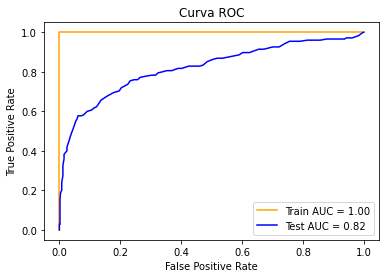

Parcelas con acierto:  30 de 35   85.71%
Exito min:  0.21 
Exito max:  0.95 
Exito promedio:  0.6491817810721686
Exito * accuracy =  0.5397482808342887
Exito * accuracy / (Exito + accuracy) =  0.36454444609458375
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       525
           1       0.70      0.55      0.62       175

    accuracy                           0.83       700
   macro avg       0.78      0.74      0.75       700
weighted avg       0.82      0.83      0.82       700



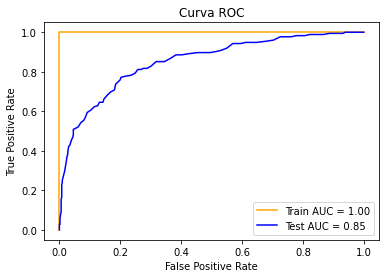

Parcelas con acierto:  29 de 35   82.86%
Exito min:  0.26 
Exito max:  1.0 
Exito promedio:  0.6345833019459322
Exito * accuracy =  0.5257975930409152
Exito * accuracy / (Exito + accuracy) =  0.35935884433425375
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       525
           1       0.50      0.42      0.46       175

    accuracy                           0.75       700
   macro avg       0.66      0.64      0.65       700
weighted avg       0.74      0.75      0.74       700



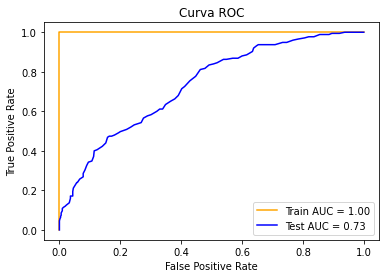

Parcelas con acierto:  22 de 35   62.86%
Exito min:  0.3151349326044987 
Exito max:  0.95 
Exito promedio:  0.590938241127701
Exito * accuracy =  0.44320368084577577
Exito * accuracy / (Exito + accuracy) =  0.3305175937655792
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       525
           1       0.58      0.45      0.51       175

    accuracy                           0.78       700
   macro avg       0.71      0.67      0.68       700
weighted avg       0.77      0.78      0.77       700



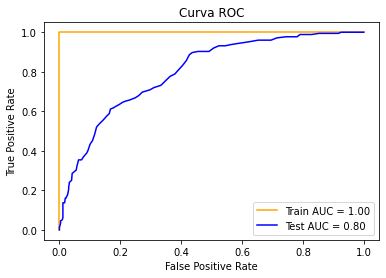

Parcelas con acierto:  23 de 35   65.71%
Exito min:  0.3 
Exito max:  0.87 
Exito promedio:  0.5967804858037169
Exito * accuracy =  0.4663413224780474
Exito * accuracy / (Exito + accuracy) =  0.33836762284420874
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       525
           1       0.64      0.54      0.59       175

    accuracy                           0.81       700
   macro avg       0.75      0.72      0.73       700
weighted avg       0.80      0.81      0.80       700



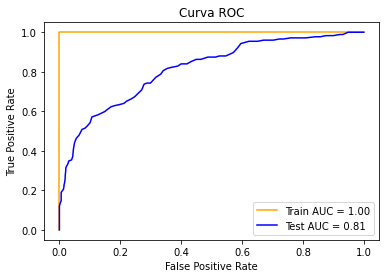

Parcelas con acierto:  30 de 35   85.71%
Exito min:  0.303506907413805 
Exito max:  0.87 
Exito promedio:  0.6010245908672356
Exito * accuracy =  0.48682991860246083
Exito * accuracy / (Exito + accuracy) =  0.3450187344383901
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       525
           1       0.58      0.52      0.55       175

    accuracy                           0.78       700
   macro avg       0.71      0.70      0.70       700
weighted avg       0.78      0.78      0.78       700



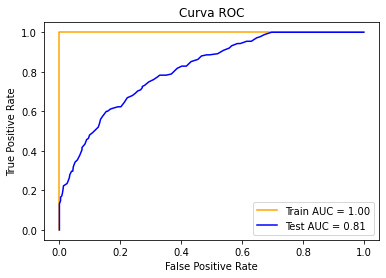

Parcelas con acierto:  28 de 35   80.00%
Exito min:  0.3 
Exito max:  0.97 
Exito promedio:  0.6137614529231539
Exito * accuracy =  0.4813643395068735
Exito * accuracy / (Exito + accuracy) =  0.3443119451169116
              precision    recall  f1-score   support

           0       0.82      0.92      0.86       510
           1       0.61      0.39      0.48       170

    accuracy                           0.79       680
   macro avg       0.71      0.65      0.67       680
weighted avg       0.77      0.79      0.77       680



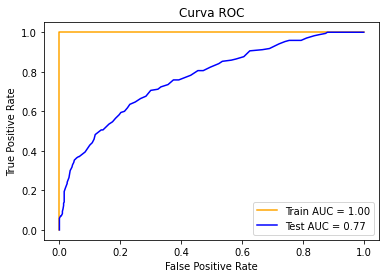

Parcelas con acierto:  19 de 34   55.88%
Exito min:  0.20012124942304488 
Exito max:  0.93 
Exito promedio:  0.571764653372999
Exito * accuracy =  0.44900341897232565
Exito * accuracy / (Exito + accuracy) =  0.3308651243120621
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       510
           1       0.64      0.54      0.59       170

    accuracy                           0.81       680
   macro avg       0.75      0.72      0.73       680
weighted avg       0.80      0.81      0.80       680



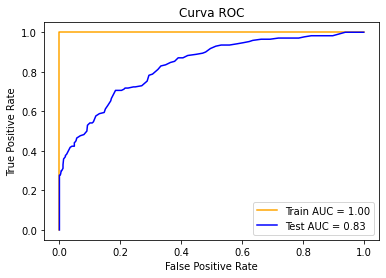

Parcelas con acierto:  28 de 34   82.35%
Exito min:  0.32 
Exito max:  0.97 
Exito promedio:  0.6233902190031104
Exito * accuracy =  0.5051294274569321
Exito * accuracy / (Exito + accuracy) =  0.35232959902259703
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       510
           1       0.64      0.46      0.54       170

    accuracy                           0.80       680
   macro avg       0.74      0.69      0.71       680
weighted avg       0.79      0.80      0.79       680



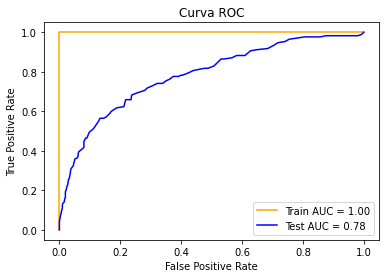

Parcelas con acierto:  26 de 34   76.47%
Exito min:  0.2 
Exito max:  0.91 
Exito promedio:  0.5691070980452375
Exito * accuracy =  0.45612260063919774
Exito * accuracy / (Exito + accuracy) =  0.3327958752028289
              precision    recall  f1-score   support

           0       0.85      0.92      0.89       510
           1       0.69      0.53      0.60       170

    accuracy                           0.82       680
   macro avg       0.77      0.72      0.74       680
weighted avg       0.81      0.82      0.81       680



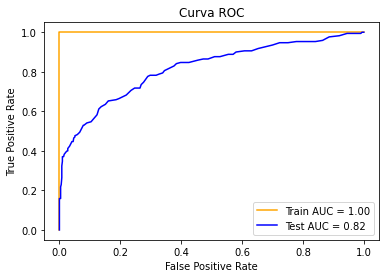

Parcelas con acierto:  26 de 34   76.47%
Exito min:  0.2660877539447184 
Exito max:  0.97 
Exito promedio:  0.6124598840550378
Exito * accuracy =  0.5034780517452443
Exito * accuracy / (Exito + accuracy) =  0.35097350008982353


In [32]:
entrenarUndersamplingNormalizacion(df=df, 
                                   normalizacion=[-1,1], 
                                   algoritmo=RandomForestClassifier, 
                                   random_state=33, 
                                   umbral=0.6, 
                                   n_splits=10
                                  )

Misma prueba pero con RandomForestRegressor --se supone q el algoritmo es igual pero obteniendo probabilidad (regresion) en vez de la clase final (clasificacion) --:

              precision    recall  f1-score   support

           0       0.87      0.90      0.89       525
           1       0.67      0.61      0.64       175

    accuracy                           0.83       700
   macro avg       0.77      0.76      0.76       700
weighted avg       0.82      0.83      0.82       700



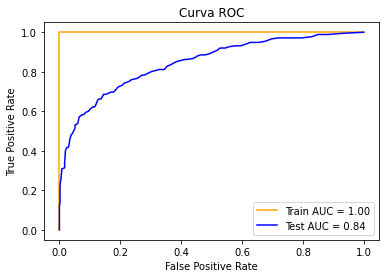

Parcelas con acierto:  32 de 35   91.43%
Exito min:  0.20814181208775098 
Exito max:  0.98 
Exito promedio:  0.7193043391128481
Exito * accuracy =  0.5949674462090558
Exito * accuracy / (Exito + accuracy) =  0.38473182120256366
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       525
           1       0.72      0.53      0.61       175

    accuracy                           0.83       700
   macro avg       0.79      0.73      0.75       700
weighted avg       0.82      0.83      0.82       700



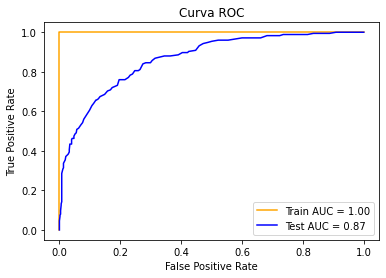

Parcelas con acierto:  29 de 35   82.86%
Exito min:  0.26 
Exito max:  0.99 
Exito promedio:  0.6771908567927428
Exito * accuracy =  0.5620684111379766
Exito * accuracy / (Exito + accuracy) =  0.3729245095966422
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       525
           1       0.55      0.50      0.52       175

    accuracy                           0.77       700
   macro avg       0.69      0.68      0.69       700
weighted avg       0.76      0.77      0.77       700



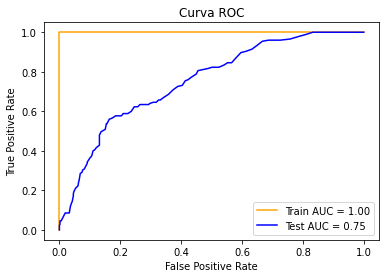

Parcelas con acierto:  25 de 35   71.43%
Exito min:  0.34 
Exito max:  0.94 
Exito promedio:  0.6336391510582546
Exito * accuracy =  0.4888073451020822
Exito * accuracy / (Exito + accuracy) =  0.3478888150935125
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       525
           1       0.63      0.59      0.61       175

    accuracy                           0.81       700
   macro avg       0.75      0.74      0.74       700
weighted avg       0.81      0.81      0.81       700



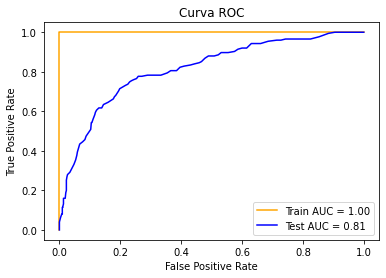

Parcelas con acierto:  32 de 35   91.43%
Exito min:  0.45348685423574203 
Exito max:  0.93 
Exito promedio:  0.6687579021519553
Exito * accuracy =  0.5416939007430839
Exito * accuracy / (Exito + accuracy) =  0.36631682573245183
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       525
           1       0.61      0.58      0.59       175

    accuracy                           0.80       700
   macro avg       0.73      0.73      0.73       700
weighted avg       0.80      0.80      0.80       700



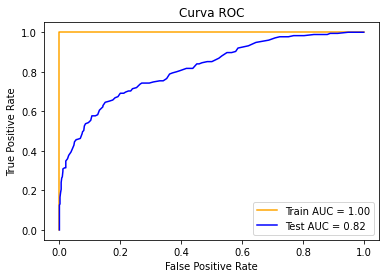

Parcelas con acierto:  29 de 35   82.86%
Exito min:  0.32961146963795623 
Exito max:  0.97 
Exito promedio:  0.6625078251403457
Exito * accuracy =  0.530952699862477
Exito * accuracy / (Exito + accuracy) =  0.362688366179631
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       525
           1       0.62      0.56      0.59       175

    accuracy                           0.80       700
   macro avg       0.74      0.72      0.73       700
weighted avg       0.80      0.80      0.80       700



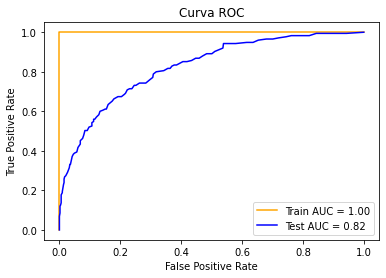

Parcelas con acierto:  30 de 35   85.71%
Exito min:  0.3 
Exito max:  0.99 
Exito promedio:  0.6741834255534938
Exito * accuracy =  0.5412729788015193
Exito * accuracy / (Exito + accuracy) =  0.3664577604553908
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       510
           1       0.64      0.48      0.55       170

    accuracy                           0.80       680
   macro avg       0.74      0.69      0.71       680
weighted avg       0.79      0.80      0.79       680



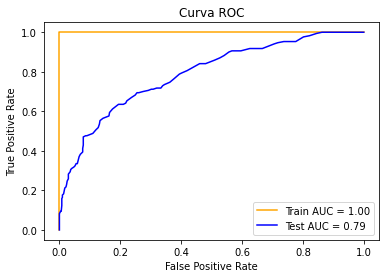

Parcelas con acierto:  23 de 34   67.65%
Exito min:  0.2920762789992915 
Exito max:  0.98 
Exito promedio:  0.6472106921899518
Exito * accuracy =  0.5187203341816525
Exito * accuracy / (Exito + accuracy) =  0.35806380685017714
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       510
           1       0.67      0.55      0.60       170

    accuracy                           0.82       680
   macro avg       0.76      0.73      0.74       680
weighted avg       0.81      0.82      0.81       680



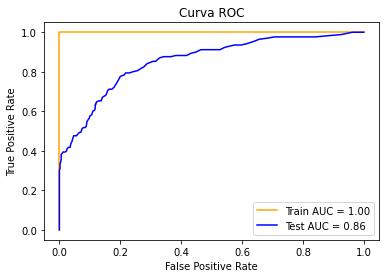

Parcelas con acierto:  27 de 34   79.41%
Exito min:  0.37662467555171797 
Exito max:  0.98 
Exito promedio:  0.6667349821560755
Exito * accuracy =  0.5461343897954912
Exito * accuracy / (Exito + accuracy) =  0.36755622937118604
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       510
           1       0.64      0.56      0.60       170

    accuracy                           0.81       680
   macro avg       0.75      0.73      0.74       680
weighted avg       0.80      0.81      0.81       680



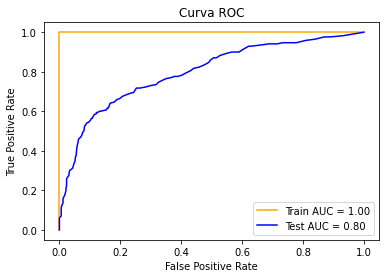

Parcelas con acierto:  27 de 34   79.41%
Exito min:  0.2825241168325339 
Exito max:  1.0 
Exito promedio:  0.6240467191350046
Exito * accuracy =  0.5056613856520406
Exito * accuracy / (Exito + accuracy) =  0.35253921012699424
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       510
           1       0.68      0.57      0.62       170

    accuracy                           0.83       680
   macro avg       0.77      0.74      0.75       680
weighted avg       0.82      0.83      0.82       680



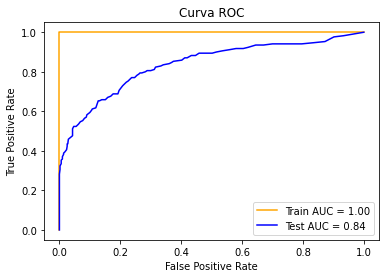

Parcelas con acierto:  26 de 34   76.47%
Exito min:  0.24815135750985645 
Exito max:  0.99 
Exito promedio:  0.6416103680831412
Exito * accuracy =  0.5302720983275373
Exito * accuracy / (Exito + accuracy) =  0.36120085615531833


In [31]:
entrenarUndersamplingNormalizacion(df=df, 
                                   normalizacion=[0,1], 
                                   algoritmo=RandomForestRegressor, 
                                   random_state=33, 
                                   umbral=0.6, 
                                   n_splits=10
                                  )

Pruebo con la version scikit-learn de XGBoost:

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       525
           1       0.70      0.67      0.68       175

    accuracy                           0.85       700
   macro avg       0.80      0.79      0.79       700
weighted avg       0.84      0.85      0.84       700



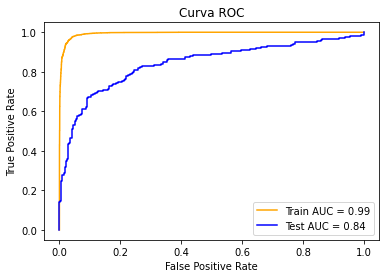

Parcelas con acierto:  30 de 35   85.71%
Exito min:  0.23372044449792068 
Exito max:  0.9833576 
Exito promedio:  0.7483230536175169
Exito * accuracy =  0.6328674967736715
Exito * accuracy / (Exito + accuracy) =  0.39702175172318127
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       525
           1       0.70      0.62      0.66       175

    accuracy                           0.84       700
   macro avg       0.79      0.77      0.78       700
weighted avg       0.83      0.84      0.84       700



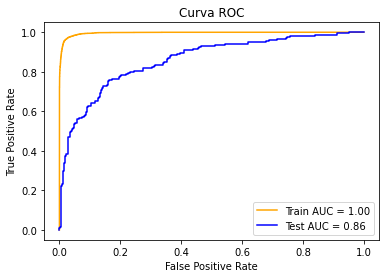

Parcelas con acierto:  30 de 35   85.71%
Exito min:  0.18376566 
Exito max:  0.9772464 
Exito promedio:  0.7289317233376825
Exito * accuracy =  0.6112613165703137
Exito * accuracy / (Exito + accuracy) =  0.3899585884888585
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       525
           1       0.55      0.54      0.55       175

    accuracy                           0.77       700
   macro avg       0.70      0.70      0.70       700
weighted avg       0.77      0.77      0.77       700



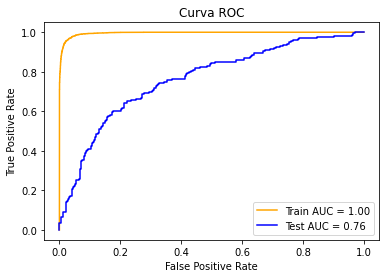

Parcelas con acierto:  30 de 35   85.71%
Exito min:  0.4137085323308095 
Exito max:  0.96574867 
Exito promedio:  0.6584907903689424
Exito * accuracy =  0.5098600119713811
Exito * accuracy / (Exito + accuracy) =  0.35585453161396796
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       525
           1       0.62      0.66      0.64       175

    accuracy                           0.81       700
   macro avg       0.75      0.76      0.76       700
weighted avg       0.82      0.81      0.82       700



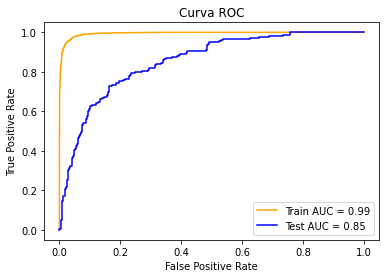

Parcelas con acierto:  31 de 35   88.57%
Exito min:  0.3970589947800052 
Exito max:  0.96625715 
Exito promedio:  0.7190660944284297
Exito * accuracy =  0.5844980110425378
Exito * accuracy / (Exito + accuracy) =  0.3815452346543256
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       525
           1       0.61      0.62      0.61       175

    accuracy                           0.81       700
   macro avg       0.74      0.74      0.74       700
weighted avg       0.81      0.81      0.81       700



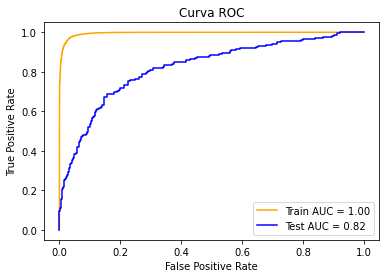

Parcelas con acierto:  31 de 35   88.57%
Exito min:  0.33158021300848756 
Exito max:  0.9730963 
Exito promedio:  0.6957462375074048
Exito * accuracy =  0.5605726827916805
Exito * accuracy / (Exito + accuracy) =  0.37335159607716967
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       525
           1       0.63      0.65      0.64       175

    accuracy                           0.82       700
   macro avg       0.75      0.76      0.76       700
weighted avg       0.82      0.82      0.82       700



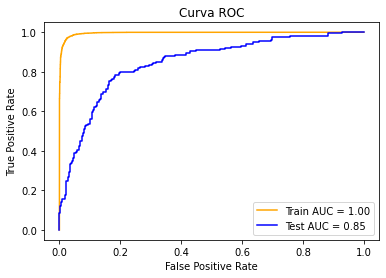

Parcelas con acierto:  32 de 35   91.43%
Exito min:  0.4845881047051331 
Exito max:  0.9671911 
Exito promedio:  0.757998840323318
Exito * accuracy =  0.6183104826065923
Exito * accuracy / (Exito + accuracy) =  0.3928991074525853
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       510
           1       0.56      0.54      0.55       170

    accuracy                           0.78       680
   macro avg       0.70      0.70      0.70       680
weighted avg       0.78      0.78      0.78       680



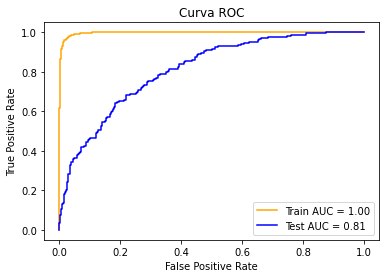

Parcelas con acierto:  27 de 34   79.41%
Exito min:  0.20918632 
Exito max:  0.96506107 
Exito promedio:  0.6723565346107218
Exito * accuracy =  0.5240425931524744
Exito * accuracy / (Exito + accuracy) =  0.36096847782057145
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       510
           1       0.68      0.61      0.64       170

    accuracy                           0.83       680
   macro avg       0.78      0.75      0.76       680
weighted avg       0.82      0.83      0.83       680



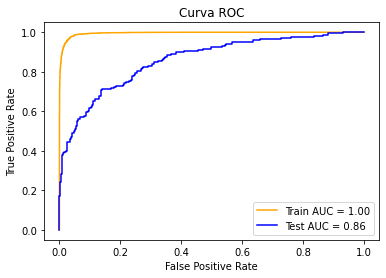

Parcelas con acierto:  29 de 34   85.29%
Exito min:  0.22985384 
Exito max:  0.9612939 
Exito promedio:  0.6829401817615216
Exito * accuracy =  0.5664386213433797
Exito * accuracy / (Exito + accuracy) =  0.37454153622540287
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       510
           1       0.54      0.55      0.54       170

    accuracy                           0.77       680
   macro avg       0.69      0.70      0.69       680
weighted avg       0.77      0.77      0.77       680



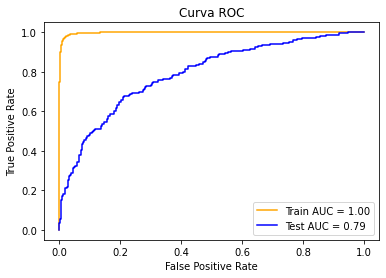

Parcelas con acierto:  29 de 34   85.29%
Exito min:  0.2687487188937425 
Exito max:  0.97763366 
Exito promedio:  0.674081212789948
Exito * accuracy =  0.518447756307563
Exito * accuracy / (Exito + accuracy) =  0.35923514820534824
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       510
           1       0.69      0.61      0.65       170

    accuracy                           0.83       680
   macro avg       0.78      0.76      0.77       680
weighted avg       0.83      0.83      0.83       680



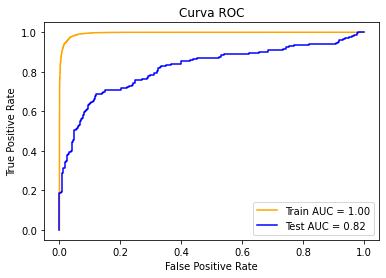

Parcelas con acierto:  29 de 34   85.29%
Exito min:  0.21934585068825554 
Exito max:  0.97191995 
Exito promedio:  0.665924765359024
Exito * accuracy =  0.5552637381743627
Exito * accuracy / (Exito + accuracy) =  0.3702379526687346


In [23]:
entrenarUndersamplingNormalizacion(df=df, 
                                   normalizacion=[0,1], 
                                   algoritmo=XGBClassifier, 
                                   random_state=33, 
                                   umbral=0.6, 
                                   n_splits=10
                                  )


Pruebo con la version scikit-learn de LGBM:

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       525
           1       0.66      0.67      0.66       175

    accuracy                           0.83       700
   macro avg       0.78      0.78      0.78       700
weighted avg       0.83      0.83      0.83       700



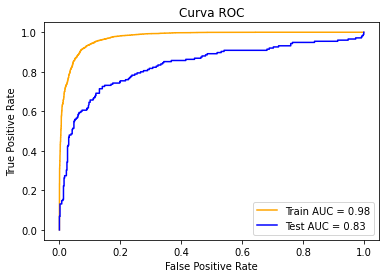

Parcelas con acierto:  31 de 35   88.57%
Exito min:  0.24912118195021557 
Exito max:  0.9462423759832248 
Exito promedio:  0.7037410135533381
Exito * accuracy =  0.5851103855543468
Exito * accuracy / (Exito + accuracy) =  0.3811372966728245
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       525
           1       0.69      0.65      0.67       175

    accuracy                           0.84       700
   macro avg       0.79      0.78      0.78       700
weighted avg       0.84      0.84      0.84       700



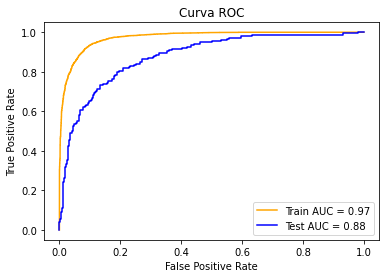

Parcelas con acierto:  32 de 35   91.43%
Exito min:  0.3745721908881158 
Exito max:  0.9414918371331467 
Exito promedio:  0.6741544641051358
Exito * accuracy =  0.566289749848314
Exito * accuracy / (Exito + accuracy) =  0.3739973452331965
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       525
           1       0.51      0.49      0.50       175

    accuracy                           0.76       700
   macro avg       0.67      0.67      0.67       700
weighted avg       0.75      0.76      0.75       700



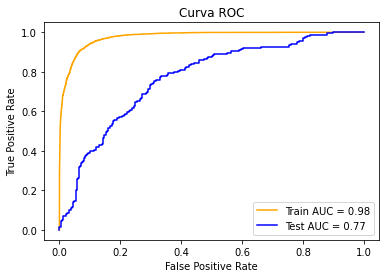

Parcelas con acierto:  28 de 35   80.00%
Exito min:  0.3805360345632512 
Exito max:  0.918542602232321 
Exito promedio:  0.6280743683804229
Exito * accuracy =  0.47464477267606237
Exito * accuracy / (Exito + accuracy) =  0.34300380428150046
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       525
           1       0.59      0.59      0.59       175

    accuracy                           0.80       700
   macro avg       0.73      0.73      0.73       700
weighted avg       0.80      0.80      0.80       700



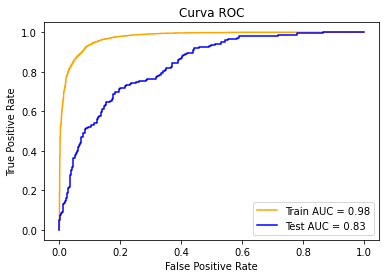

Parcelas con acierto:  28 de 35   80.00%
Exito min:  0.34727994836820975 
Exito max:  0.8927275165165878 
Exito promedio:  0.650026359256763
Exito * accuracy =  0.5172352601514528
Exito * accuracy / (Exito + accuracy) =  0.35776490199029476
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       525
           1       0.61      0.55      0.58       175

    accuracy                           0.80       700
   macro avg       0.73      0.72      0.72       700
weighted avg       0.79      0.80      0.80       700



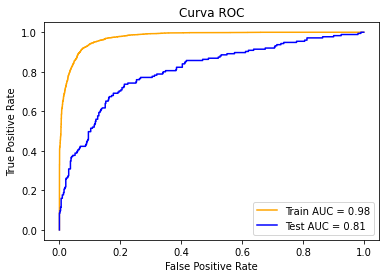

Parcelas con acierto:  30 de 35   85.71%
Exito min:  0.24744291617972541 
Exito max:  0.9271396740953437 
Exito promedio:  0.6444491445667654
Exito * accuracy =  0.514638674018317
Exito * accuracy / (Exito + accuracy) =  0.3566398730540008
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       525
           1       0.60      0.59      0.60       175

    accuracy                           0.80       700
   macro avg       0.73      0.73      0.73       700
weighted avg       0.80      0.80      0.80       700



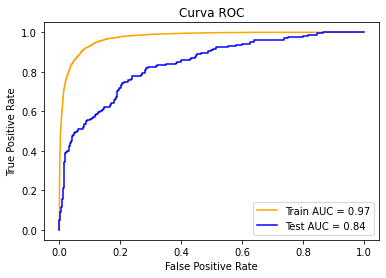

Parcelas con acierto:  29 de 35   82.86%
Exito min:  0.4313151379692825 
Exito max:  0.9067203987459339 
Exito promedio:  0.6631333187242832
Exito * accuracy =  0.5295593216669633
Exito * accuracy / (Exito + accuracy) =  0.3622888429737242
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       510
           1       0.63      0.50      0.56       170

    accuracy                           0.80       680
   macro avg       0.74      0.70      0.71       680
weighted avg       0.79      0.80      0.79       680



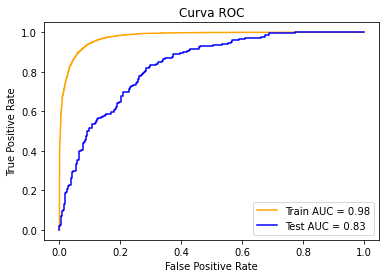

Parcelas con acierto:  26 de 34   76.47%
Exito min:  0.2768659444093084 
Exito max:  0.8990767989931766 
Exito promedio:  0.6215519213168953
Exito * accuracy =  0.49815558399662935
Exito * accuracy / (Exito + accuracy) =  0.35006866065203274
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       510
           1       0.63      0.61      0.62       170

    accuracy                           0.81       680
   macro avg       0.75      0.74      0.75       680
weighted avg       0.81      0.81      0.81       680



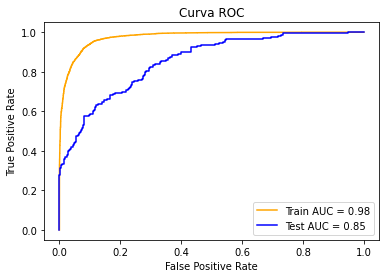

Parcelas con acierto:  28 de 34   82.35%
Exito min:  0.33112552176882065 
Exito max:  0.9466229648617621 
Exito promedio:  0.6646810433009976
Exito * accuracy =  0.5405420837433114
Exito * accuracy / (Exito + accuracy) =  0.3657460642781931
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       510
           1       0.58      0.58      0.58       170

    accuracy                           0.79       680
   macro avg       0.72      0.72      0.72       680
weighted avg       0.79      0.79      0.79       680



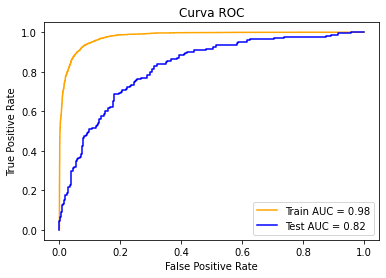

Parcelas con acierto:  30 de 34   88.24%
Exito min:  0.29471347704580897 
Exito max:  0.8998656974225315 
Exito promedio:  0.6267347018094283
Exito * accuracy =  0.4940144120144905
Exito * accuracy / (Exito + accuracy) =  0.34913419608648083
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       510
           1       0.68      0.56      0.62       170

    accuracy                           0.82       680
   macro avg       0.77      0.74      0.75       680
weighted avg       0.82      0.82      0.82       680



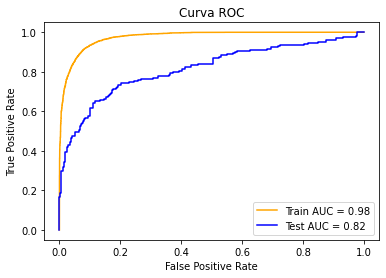

Parcelas con acierto:  25 de 34   73.53%
Exito min:  0.22860825295009887 
Exito max:  0.9127865651856617 
Exito promedio:  0.6424527627088504
Exito * accuracy =  0.5300235292348016
Exito * accuracy / (Exito + accuracy) =  0.3611860924616084


In [30]:
entrenarUndersamplingNormalizacion(df=df, 
                                   normalizacion=[-1,1], 
                                   algoritmo=LGBMClassifier, 
                                   random_state=33, 
                                   umbral=0.6, 
                                   n_splits=10
                                  )

Ahora voy a probar con XGBoost y con LGBM con sus propias librerias:

Voy a probar con los parametros que ha usado Mario:

objective: binary:logistic
use_label_encoder: None
base_score: 0.5
booster: gbtree
callbacks: None
colsample_bylevel: 1
colsample_bynode: 1
colsample_bytree: 0.9657249704671855
early_stopping_rounds: None
enable_categorical: False
eval_metric: auc
feature_types: None
gamma: 0
gpu_id: 0
grow_policy: depthwise
importance_type: None
interaction_constraints: 
learning_rate: 0.092
max_bin: 256
max_cat_threshold: 64
max_cat_to_onehot: 4
max_delta_step: 0
max_depth: 141
max_leaves: 0
min_child_weight: 2.8915804320720007
missing: nan
monotone_constraints: ()
n_estimators: 145
n_jobs: 0
num_parallel_tree: 1
predictor: gpu_predictor
random_state: 2027
reg_alpha: 0
reg_lambda: 2.4958860070369515
sampling_method: uniform
scale_pos_weight: 5.6052968104215815
subsample: 1
tree_method: gpu_hist
validate_parameters: 1
verbosity: 0
min_child_samples: 14
subsample_for_bin: 5
max_leaf_nodes: 27
eta: 0.037211579035864056
seed: 2027
              precision    recall  f1-score   support

           0       

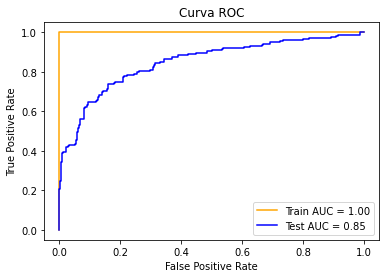

Parcelas con acierto:  32 de 35   91.43%
Exito min:  0.37073229163393323 
Exito max:  0.9958579 
Exito promedio:  0.8479967117179997
Exito * accuracy =  0.6844544887438141
Exito * accuracy / (Exito + accuracy) =  0.41353279301689777
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       525
           1       0.62      0.77      0.69       175

    accuracy                           0.83       700
   macro avg       0.77      0.81      0.79       700
weighted avg       0.84      0.83      0.83       700



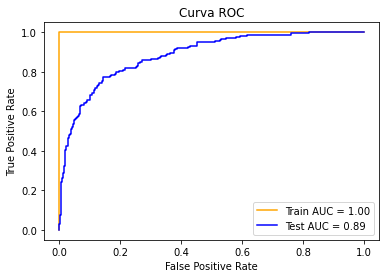

Parcelas con acierto:  32 de 35   91.43%
Exito min:  0.20398143 
Exito max:  0.9929014 
Exito promedio:  0.8252890929389349
Exito * accuracy =  0.6826319783023477
Exito * accuracy / (Exito + accuracy) =  0.41310746761375483
              precision    recall  f1-score   support

           0       0.87      0.77      0.82       525
           1       0.48      0.65      0.55       175

    accuracy                           0.74       700
   macro avg       0.68      0.71      0.69       700
weighted avg       0.77      0.74      0.75       700



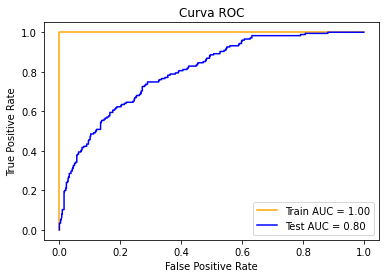

Parcelas con acierto:  31 de 35   88.57%
Exito min:  0.45668789916839925 
Exito max:  0.9922604 
Exito promedio:  0.7919467638348376
Exito * accuracy =  0.5860406052377799
Exito * accuracy / (Exito + accuracy) =  0.382546325415889
              precision    recall  f1-score   support

           0       0.90      0.81      0.85       525
           1       0.56      0.74      0.64       175

    accuracy                           0.79       700
   macro avg       0.73      0.77      0.74       700
weighted avg       0.82      0.79      0.80       700



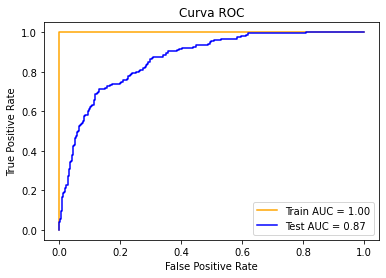

Parcelas con acierto:  33 de 35   94.29%
Exito min:  0.5243706825867449 
Exito max:  0.9880873 
Exito promedio:  0.857689844571853
Exito * accuracy =  0.6763497060052327
Exito * accuracy / (Exito + accuracy) =  0.410839832679686
              precision    recall  f1-score   support

           0       0.90      0.78      0.83       525
           1       0.52      0.73      0.61       175

    accuracy                           0.77       700
   macro avg       0.71      0.75      0.72       700
weighted avg       0.80      0.77      0.78       700



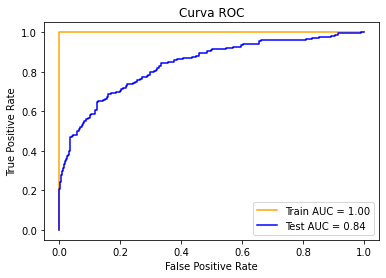

Parcelas con acierto:  32 de 35   91.43%
Exito min:  0.44835358553665333 
Exito max:  0.9969913 
Exito promedio:  0.8094107713407027
Exito * accuracy =  0.6209336917285105
Exito * accuracy / (Exito + accuracy) =  0.3938551029981569
              precision    recall  f1-score   support

           0       0.90      0.81      0.86       525
           1       0.57      0.74      0.64       175

    accuracy                           0.79       700
   macro avg       0.74      0.78      0.75       700
weighted avg       0.82      0.79      0.80       700



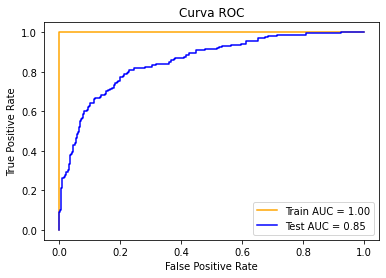

Parcelas con acierto:  32 de 35   91.43%
Exito min:  0.42050991587139885 
Exito max:  0.9931235 
Exito promedio:  0.8221561313547587
Exito * accuracy =  0.653026870047494
Exito * accuracy / (Exito + accuracy) =  0.4039903271551035
              precision    recall  f1-score   support

           0       0.88      0.81      0.84       510
           1       0.54      0.66      0.59       170

    accuracy                           0.77       680
   macro avg       0.71      0.74      0.72       680
weighted avg       0.79      0.77      0.78       680



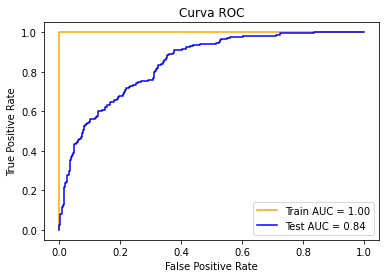

Parcelas con acierto:  31 de 34   91.18%
Exito min:  0.30156341418092575 
Exito max:  0.99434495 
Exito promedio:  0.8122176928410209
Exito * accuracy =  0.6282742741682015
Exito * accuracy / (Exito + accuracy) =  0.39620080171889255
              precision    recall  f1-score   support

           0       0.90      0.83      0.86       510
           1       0.58      0.72      0.65       170

    accuracy                           0.80       680
   macro avg       0.74      0.78      0.75       680
weighted avg       0.82      0.80      0.81       680



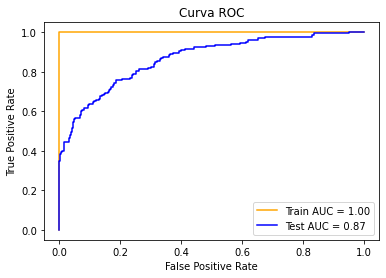

Parcelas con acierto:  30 de 34   88.24%
Exito min:  0.39800674 
Exito max:  0.9963838 
Exito promedio:  0.8390398030079114
Exito * accuracy =  0.6724657244695761
Exito * accuracy / (Exito + accuracy) =  0.40991250531486767
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       510
           1       0.53      0.72      0.61       170

    accuracy                           0.77       680
   macro avg       0.71      0.75      0.72       680
weighted avg       0.80      0.77      0.78       680



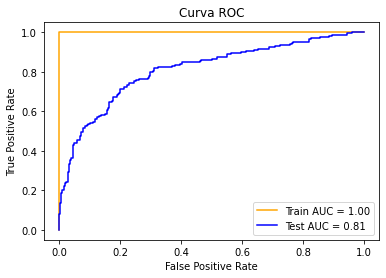

Parcelas con acierto:  31 de 34   91.18%
Exito min:  0.4124219221374141 
Exito max:  0.9966696 
Exito promedio:  0.7932744461707077
Exito * accuracy =  0.6112879555786043
Exito * accuracy / (Exito + accuracy) =  0.3908833958529072
              precision    recall  f1-score   support

           0       0.90      0.83      0.86       510
           1       0.59      0.72      0.65       170

    accuracy                           0.80       680
   macro avg       0.74      0.78      0.76       680
weighted avg       0.82      0.80      0.81       680



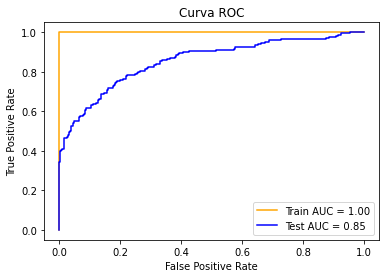

Parcelas con acierto:  30 de 34   88.24%
Exito min:  0.3392280253594549 
Exito max:  0.9930633 
Exito promedio:  0.7994146505891898
Exito * accuracy =  0.6430585498121866
Exito * accuracy / (Exito + accuracy) =  0.4009527113904509


In [29]:
import xgboost as xgb
import joblib

# Cargar el modelo
xgb_model = joblib.load('bestmodels/Xgbm_model_481')

# Obtener los parámetros del modelo
params = xgb_model.get_params()

# Imprimir los nombres de los parámetros y sus valores
for key, value in params.items():
    print(f"{key}: {value}")
    
entrenarUndersamplingNormalizacion(df=df, 
                                   normalizacion=[-1,1], 
                                   params=params, 
                                   random_state=33, 
                                   umbral=0.6, 
                                   n_splits=10,
                                   XGBoost = True,
                                  )    

En XGBoost, Mario ha logrado obtener un accuracy de 0.98 con estos parametros pero yo lo maximo que he conseguido es 0.78, asi que deberia probar con distintas columnas de informacion.

boosting_type: gbdt
class_weight: None
colsample_bytree: 1.0
importance_type: split
learning_rate: 0.11533354417560811
max_depth: 99
min_child_samples: 73
min_child_weight: 0.001
min_split_gain: 0.0
n_estimators: 426
n_jobs: -1
num_leaves: 44
objective: None
random_state: 2027
reg_alpha: 0.0
reg_lambda: 0.0
silent: True
subsample: 1.0
subsample_for_bin: 200000
subsample_freq: 0
lambda_l1: 0.005362644132692479
lambda_l2: 0.09014662034945402
feature_fraction: 0.9237744994047856
bagging_fraction: 0.9285725886092697
bagging_freq: 2
min_data_in_leaf: 2
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.9237744994047856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9237744994047856
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.9285725886092697, subs

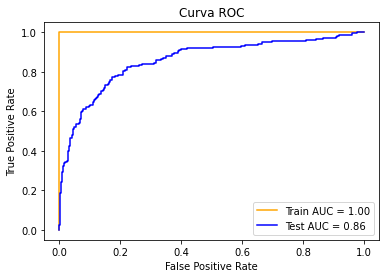

Parcelas con acierto:  29 de 35   82.86%
Exito min:  0.2579873457959305 
Exito max:  1.2424871381810885 
Exito promedio:  0.7481458129227948
Exito * accuracy =  0.6295112625878945
Exito * accuracy / (Exito + accuracy) =  0.396025042165466
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.9237744994047856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9237744994047856
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.9285725886092697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285725886092697
[LightGBM] [Warning] lambda_l1 is set=0.005362644132692479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362644132692479
[LightGBM] [Warning] lambda_l2 is set=0.09014662034945402, reg_lambda=0.0 will be ignored. Current v

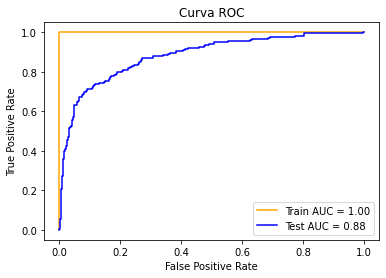

Parcelas con acierto:  32 de 35   91.43%
Exito min:  0.28339572075409425 
Exito max:  1.0505067439063371 
Exito promedio:  0.7334819418480667
Exito * accuracy =  0.6349857953713264
Exito * accuracy / (Exito + accuracy) =  0.39706559109336587
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.9237744994047856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9237744994047856
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.9285725886092697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285725886092697
[LightGBM] [Warning] lambda_l1 is set=0.005362644132692479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362644132692479
[LightGBM] [Warning] lambda_l2 is set=0.09014662034945402, reg_lambda=0.0 will be ignored. Curren

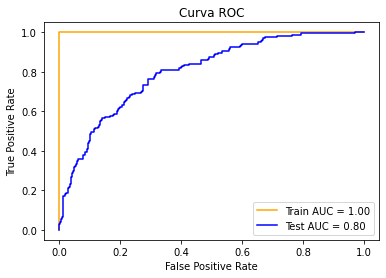

Parcelas con acierto:  27 de 35   77.14%
Exito min:  0.36772534582675276 
Exito max:  1.0735374569635636 
Exito promedio:  0.7018927299500705
Exito * accuracy =  0.5524898488606983
Exito * accuracy / (Exito + accuracy) =  0.3710387136813397
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.9237744994047856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9237744994047856
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.9285725886092697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285725886092697
[LightGBM] [Warning] lambda_l1 is set=0.005362644132692479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362644132692479
[LightGBM] [Warning] lambda_l2 is set=0.09014662034945402, reg_lambda=0.0 will be ignored. Current

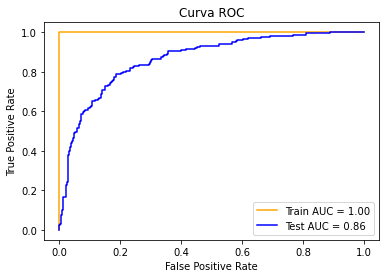

Parcelas con acierto:  31 de 35   88.57%
Exito min:  0.4087689534198529 
Exito max:  0.9963537858160638 
Exito promedio:  0.7191689578625479
Exito * accuracy =  0.5979376192514326
Exito * accuracy / (Exito + accuracy) =  0.385617549335829
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.9237744994047856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9237744994047856
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.9285725886092697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285725886092697
[LightGBM] [Warning] lambda_l1 is set=0.005362644132692479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362644132692479
[LightGBM] [Warning] lambda_l2 is set=0.09014662034945402, reg_lambda=0.0 will be ignored. Current v

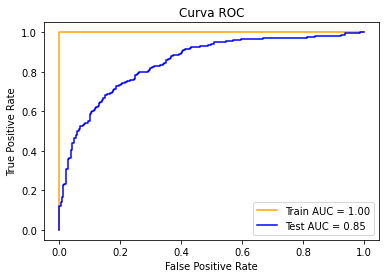

Parcelas con acierto:  30 de 35   85.71%
Exito min:  0.2943059435398862 
Exito max:  1.0987785428305932 
Exito promedio:  0.7164675906534751
Exito * accuracy =  0.5844328489473347
Exito * accuracy / (Exito + accuracy) =  0.3814382991742533
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.9237744994047856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9237744994047856
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.9285725886092697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285725886092697
[LightGBM] [Warning] lambda_l1 is set=0.005362644132692479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362644132692479
[LightGBM] [Warning] lambda_l2 is set=0.09014662034945402, reg_lambda=0.0 will be ignored. Current 

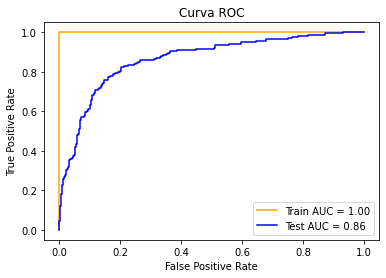

Parcelas con acierto:  31 de 35   88.57%
Exito min:  0.4318619974297022 
Exito max:  1.1194033116390671 
Exito promedio:  0.7096137403500747
Exito * accuracy =  0.5899931384053478
Exito * accuracy / (Exito + accuracy) =  0.38285330253157507
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.9237744994047856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9237744994047856
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.9285725886092697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285725886092697
[LightGBM] [Warning] lambda_l1 is set=0.005362644132692479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362644132692479
[LightGBM] [Warning] lambda_l2 is set=0.09014662034945402, reg_lambda=0.0 will be ignored. Current

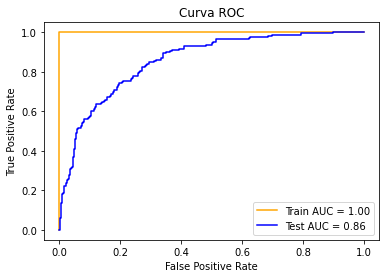

Parcelas con acierto:  26 de 34   76.47%
Exito min:  0.33264368955924406 
Exito max:  1.0627048649372937 
Exito promedio:  0.7082573432189359
Exito * accuracy =  0.5791045335731299
Exito * accuracy / (Exito + accuracy) =  0.3795156058256221
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.9237744994047856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9237744994047856
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.9285725886092697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285725886092697
[LightGBM] [Warning] lambda_l1 is set=0.005362644132692479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362644132692479
[LightGBM] [Warning] lambda_l2 is set=0.09014662034945402, reg_lambda=0.0 will be ignored. Current

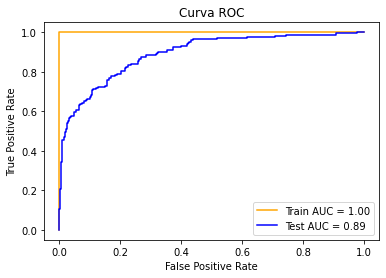

Parcelas con acierto:  29 de 34   85.29%
Exito min:  0.37118315012257513 
Exito max:  0.9870385209953934 
Exito promedio:  0.7156314633303184
Exito * accuracy =  0.6103915422523304
Exito * accuracy / (Exito + accuracy) =  0.3891382055024275
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.9237744994047856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9237744994047856
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.9285725886092697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285725886092697
[LightGBM] [Warning] lambda_l1 is set=0.005362644132692479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362644132692479
[LightGBM] [Warning] lambda_l2 is set=0.09014662034945402, reg_lambda=0.0 will be ignored. Current

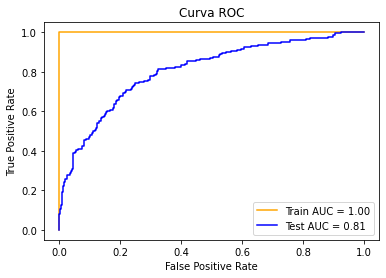

Parcelas con acierto:  28 de 34   82.35%
Exito min:  0.4062565497732263 
Exito max:  1.0159527850453045 
Exito promedio:  0.6694829145131802
Exito * accuracy =  0.5277100620280362
Exito * accuracy / (Exito + accuracy) =  0.3620110244240496
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.9237744994047856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9237744994047856
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.9285725886092697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285725886092697
[LightGBM] [Warning] lambda_l1 is set=0.005362644132692479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362644132692479
[LightGBM] [Warning] lambda_l2 is set=0.09014662034945402, reg_lambda=0.0 will be ignored. Current 

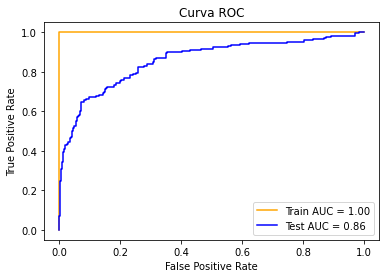

Parcelas con acierto:  25 de 34   73.53%
Exito min:  0.3107297469482238 
Exito max:  1.0282085531600238 
Exito promedio:  0.6864030851052415
Exito * accuracy =  0.588489703847582
Exito * accuracy / (Exito + accuracy) =  0.3812064172244997


In [28]:
import lightgbm as lgb
import joblib

# Cargar el modelo
lgb_model = joblib.load('bestmodels/lgbm_model_152')

# Obtener los parámetros del modelo
params = lgb_model.get_params()

# Imprimir los nombres de los parámetros y sus valores
for key, value in params.items():
    print(f"{key}: {value}")
    
entrenarUndersamplingNormalizacion(df=df, 
                                   normalizacion=[0,1], 
                                   params=params, 
                                   random_state=33, 
                                   umbral=0.6, 
                                   n_splits=10,
                                   LGBM = True,
                                  )    


En LGBM, Mario ha logrado obtener un accuracy de 0.88 con estos parametros pero yo lo maximo que he conseguido es 0.87, asi que estoy bastante cerca de sus resultados.

Los mejores modelos obtenido en todos los notebooks hasta ahora están en este notebook y son los siguientes:
- XGBoost, norm = [-1, 1], threshold = 0.6: Buen TestAUC (el mas alto), buen exito promedio y buen recall de la clase 1.
 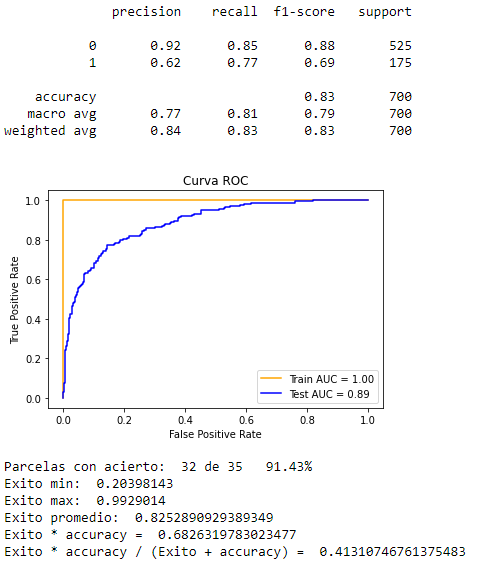
 - LGBM, norm = [-1, 1], threshold = 0.6: Muy buen accuracy, f1-score y testAUC
 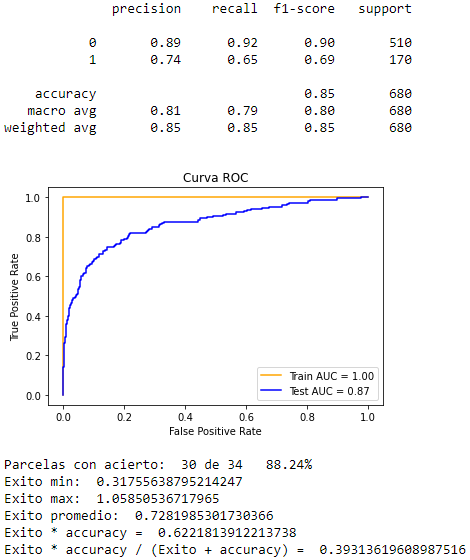 
 - LGBM, norm = [-1, 1], threshold = 0.6: Mejor accuracy (0.86), el mejor f1-score y TestAUC visto hasta ahora 
 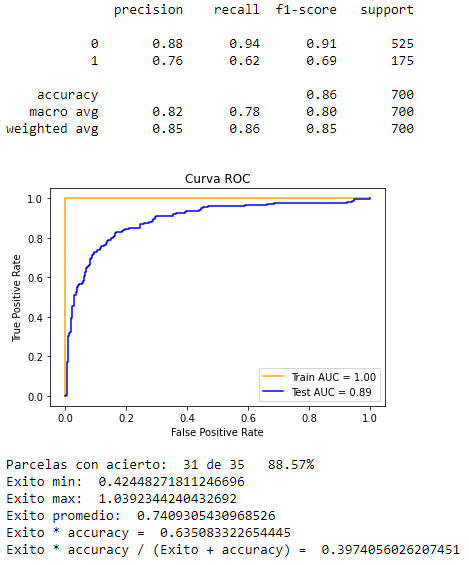
 - LGBM, norm = [0, 1], threshold = 0.6: Mejor accuracy aun (0.87), el mejor f1-score (aun mejor). El 2º mejor TestAUC visto hasta ahora 
 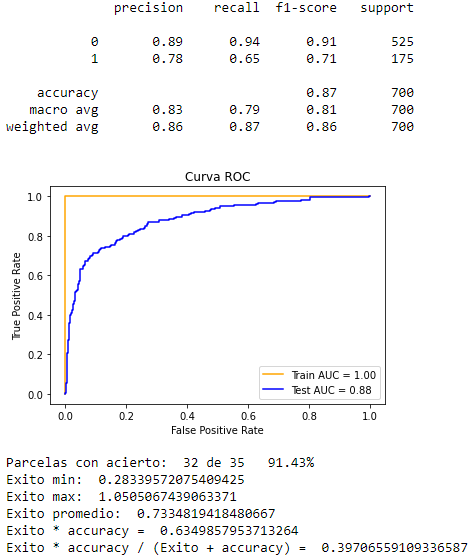